In [20]:
#from Raw data.

import pandas as pd
df= pd.read_csv("/Users/alessandrobragato//0_milan_real_estate/folder/milano_house_prices_raw_data.csv")
df.head(10)
#abbiamo eliminato tutte le colonne con una percentuale di scrittura inferiore a 25%
threshold = len(df) * 0.25  # Set threshold to 25% of the number of rows 
#Questo significa che qualsiasi colonna con più del 25% dei valori mancanti (o "NaN") verrà eliminata dal DataFrame.
#La motivazione principale dietro questa scelta è garantire che il dataset sia sufficientemente completo e di alta qualità per analisi future
df = df.dropna(thresh=threshold, axis=1)

df.columns = df.columns.str.lower()
print(df.head(10))

   unnamed: 0   price_euro number_rooms area_m2 bathrooms floor_number  \
0           0    € 289,000            3   100m²         1            4   
1           1    € 950,000        234m²       3         5          NaN   
2           2    € 398,000            2    78m²         1            2   
3           3    € 420,000            3    85m²         1            2   
4           4    € 780,000            3    80m²         1            5   
5           5    € 395,000            2    50m²         1            4   
6           6    € 369,000            3    84m²         1            1   
7           7    € 330,000            3   130m²         1            3   
8           8    € 198,000            3    80m²         1            6   
9           9  € 1,080,000        190m²       2       NaN          NaN   

                                         description  \
0  Si propone in vendita in esclusiva un ampio ap...   
1  A few steps from numerous neighborhood service...   
2  RIF: Divina Se

In [21]:
#df.to_csv("/Users/alessandrobragato/0_milan_real_estate/milano_house_prices_cleaned_data.csv", index=False)
#ho salvato il nuovo dataseti in un flie csv

In [22]:
df= pd.read_csv("/Users/alessandrobragato//0_milan_real_estate/milano_house_prices_cleaned_data.csv")
#overview delle  colonne che sono rimaste presenti nel dataset e il loro numero totale
numero_colonne = df.shape[1]

# Nomi delle colonne
nomi_colonne = df.columns.tolist()

print(f"Numero di colonne totali: {numero_colonne}")
print("Nomi delle colonne:")
print(nomi_colonne)

Numero di colonne totali: 30
Nomi delle colonne:
['Unnamed: 0', 'price_euro', 'number_rooms', 'area_m2', 'bathrooms', 'floor_number', 'description', 'Reference and listing Date', 'contract', 'type', 'surface', 'rooms', 'floor', 'total building floors', 'availability', 'other features', 'price', 'condominium fees', 'deposit', 'year of construction', 'condition', 'heating', 'Air conditioner', 'Energy Efficiency', 'city', 'neighborhood', 'street', 'URL', 'latitudine', 'longitudine']


In [23]:
# Converti tutti i valori testuali in minuscolo
df = df.map(lambda s: s.lower() if type(s) == str else s)

#scelgo delle colonne da manternere su cui fare la regressione, le altre verranno eliminate e queste ora verrano pulite
#colonne scelte su nessuna base specifica ma per "euristiche"
colonne_da_mantenere = ['area_m2','number_rooms','bathrooms', 
                        'floor_number', 'condominium fees', 
                        'year of construction','condition', 
                        'heating','Energy Efficiency',
                        'neighborhood', 'street', 'price_euro']
# Ottieni l'elenco di tutte le colonne nel DataFrame originale
tutte_le_colonne = df.columns
# Calcola le colonne da eliminare (quelle non incluse in colonne_da_mantenere)
colonne_da_eliminare = [colonna for colonna in tutte_le_colonne if colonna not in colonne_da_mantenere]
# Elimina le colonne non desiderate
df = df.drop(colonne_da_eliminare, axis=1)

***Pulizia e pretrattamento colonne***

In [24]:
#price_euro 
# Colonna da modificare
colonna_da_modificare = 'price_euro'
# Converti la colonna in stringa
df[colonna_da_modificare] = df[colonna_da_modificare].astype(str)
# Rimuovi le parole specifiche dalla colonna di tipo oggetto
df[colonna_da_modificare] = df[colonna_da_modificare].str.replace('€', '', regex=False)
df[colonna_da_modificare] = df[colonna_da_modificare].str.replace('from', '', regex=False)
df[colonna_da_modificare] = df[colonna_da_modificare].str.replace('Price on application', '', regex=False)
df[colonna_da_modificare] = df[colonna_da_modificare].str.replace(',', '', regex=False)
# Converti la colonna in valori numerici, forzando i valori non numerici a NaN
df[colonna_da_modificare] = pd.to_numeric(df[colonna_da_modificare], errors='coerce')
# Calcola la mediana della colonna ignorando i valori NaN
mediana_price_euro = df[colonna_da_modificare].median()
# Riempi i valori NaN con la mediana calcolata
df[colonna_da_modificare].fillna(mediana_price_euro)
# Verifica se ci sono valori NaN nella colonna 'price_euro'
if df[colonna_da_modificare].isna().sum() > 0:
    # Sostituisci i valori NaN con la mediana calcolata
    df[colonna_da_modificare].fillna(mediana_price_euro, inplace=True)

#area_m2
# Converti la colonna 'area_m2' in stringa
df['area_m2'] = df['area_m2'].astype(str)
# Rimuovi il testo "m²" dalla colonna 'area_m2'
df['area_m2'] = df['area_m2'].str.replace('m²', '', regex=False)
# Converti la colonna 'area_m2' in valori numerici, forzando i valori non numerici a NaN
df['area_m2'] = pd.to_numeric(df['area_m2'], errors='coerce')
# Calcola la mediana della colonna 'area_m2' ignorando i valori NaN
mediana_area = df['area_m2'].median()
# Calcola il primo e il terzo quartile per 'area_m2'
Q1_area = df['area_m2'].quantile(0.25)
Q3_area = df['area_m2'].quantile(0.75)
# Calcola l'intervallo interquartile (IQR) per 'area_m2'
IQR_area = Q3_area - Q1_area
# Definisci i limiti per identificare gli outlier per la colonna 'area_m2'
lower_bound_area = Q1_area - 1.5 * IQR_area
upper_bound_area = Q3_area + 1.5 * IQR_area
# Sostituisci gli outlier con la mediana
df.loc[(df['area_m2'] < lower_bound_area) | (df['area_m2'] > upper_bound_area), 'area_m2'] = mediana_area
# Riempi i valori NaN con la mediana calcolata
df['area_m2'].fillna(mediana_area, inplace=True)
# Definisci la colonna da modificare
colonna_da_modificare = 'area_m2'
# Converti la colonna in valori numerici, forzando i valori non numerici a NaN
df[colonna_da_modificare] = pd.to_numeric(df[colonna_da_modificare], errors='coerce')
# Calcola la mediana della colonna ignorando i valori NaN
mediana_area = df[colonna_da_modificare].median()
# Sostituisci i valori al di sotto di 19 con la mediana
df.loc[df[colonna_da_modificare] < 19, colonna_da_modificare] = mediana_area
# Riempi i valori NaN con la mediana calcolata
df[colonna_da_modificare].fillna(mediana_area, inplace=True)


#number_rooms
colonna_originale = df['number_rooms'].copy()
# Converti la colonna 'number_rooms' in stringa
df['number_rooms'] = df['number_rooms'].astype(str)
# Rimuovi il testo ",m²" e "m²" dalla colonna 'number_rooms'
df['number_rooms'] = df['number_rooms'].str.replace('m²', '', regex=False)
# Converti la colonna 'number_rooms' in valori numerici, forzando i valori non numerici a NaN
df['number_rooms'] = pd.to_numeric(df['number_rooms'], errors='coerce')
# Calcola la mediana della colonna 'number_rooms' ignorando i valori NaN
mediana_rooms = df['number_rooms'].median()
# Riempi i valori NaN e i valori originariamente stringa con la mediana calcolata
df['number_rooms'].fillna(mediana_rooms, inplace=True)
df.loc[colonna_originale.isin(df['number_rooms'].astype(str)), 'number_rooms'] = mediana_rooms


# bathrooms
df['bathrooms'] = df['bathrooms'].astype(str)
df['bathrooms'] = df['bathrooms'].str.replace('m²', '', regex=False)
df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')
mediana_bathrooms = df['bathrooms'].median()
df['bathrooms'].fillna(mediana_bathrooms, inplace=True)

# floor_number
df['floor_number'] = df['floor_number'].astype(str)
df['floor_number'] = df['floor_number'].str.replace('m²', '', regex=False)
df['floor_number'] = pd.to_numeric(df['floor_number'], errors='coerce')
mediana_floor_number = df['floor_number'].median()
df['floor_number'].fillna(mediana_floor_number, inplace=True)

# year of construction
mediana_year_of_construction = df['year of construction'].median()
df['year of construction'].fillna(mediana_year_of_construction, inplace=True)
df['year of construction'] = df['year of construction'].replace(' ', mediana_year_of_construction)

# condominium fees
colonna_da_modificare = 'condominium fees'
df[colonna_da_modificare] = df[colonna_da_modificare].astype(str)
df[colonna_da_modificare] = df[colonna_da_modificare].str.replace('€', '', regex=False)
df[colonna_da_modificare] = df[colonna_da_modificare].str.replace('/mese', '', regex=False)
df[colonna_da_modificare] = df[colonna_da_modificare].str.replace('/month', '', regex=False)
df[colonna_da_modificare] = df[colonna_da_modificare].replace(['No condominium fees', 'nan'], pd.NA)
df[colonna_da_modificare] = pd.to_numeric(df[colonna_da_modificare], errors='coerce')
mediana_condominium_fees = df[colonna_da_modificare].median()
df[colonna_da_modificare].fillna(mediana_condominium_fees, inplace=True)


# street#
df['street'] = df['street'].astype(str)
# Gestione dei valori NaN nella colonna 'street'
if df['street'].dtype == 'float64' or df['street'].dtype == 'int64':
    mediana_street = df['street'].median()
    df['street'].fillna(mediana_street, inplace=True)
else:
    modalità_street = df['street'].mode()[0]
    df['street'].fillna(modalità_street, inplace=True)



/var/folders/zl/h8y9h0pj3c3cdg2k47s2plw00000gn/T/ipykernel_24920/2588666540.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[colonna_da_modificare].fillna(mediana_price_euro, inplace=True)
/var/folders/zl/h8y9h0pj3c3cdg2k47s2plw00000gn/T/ipykernel_24920/2588666540.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are

***OHE & FREQUENCY***

In [25]:
# ohe e frequency
colonne_ohe = ['condition', 'heating']
colonna_frequency = ['neighborhood', 'street']

# Verifica se le colonne esistono nel DataFrame prima di applicare One-Hot Encoding
colonne_ohe = [colonna for colonna in colonne_ohe if colonna in df.columns]

# Applica One-Hot Encoding alle colonne specificate
if colonne_ohe:
	df = pd.get_dummies(df, columns=colonne_ohe)

	# Frequency encoding per le colonne specificate
	for colonna in colonna_frequency:
		if colonna in df.columns:
			frequenze = df[colonna].value_counts()
			df[colonna] = df[colonna].map(frequenze)



In [26]:
# Select features and target variable
features = ['number_rooms', 'area_m2', 'bathrooms', 'floor_number', 'condominium fees',
            'year of construction', 'heating', 'condition_Excellent / Refurbished', 
            'condition_Good condition / Liveable', 'condition_New / Under construction', 
            'condition_Not open to participation', 'condition_Open to participate', 
            'condition_To be refurbished']
target = 'price_euro'

In [27]:
# Ensure the columns specified in features exist in the dataframe
existing_features = [feature for feature in features if feature in df.columns]
print("Le colonne presenti in existing_features sono:")
for colonna in existing_features:
    print(colonna)

    # Verifica se ci sono valori NaN nelle colonne in existing_features
    nan_columns = df[existing_features].isna().sum()
    nan_columns = nan_columns[nan_columns > 0]

    if not nan_columns.empty:
        print("Le seguenti colonne contengono valori NaN:")
        print(nan_columns)
    else:
        print("Non ci sono valori NaN nelle colonne specificate.")
    # Stampa le colonne che continuano ad avere valori NaN e il numero di valori per colonna
    nan_columns = df[existing_features].isna().sum()
    nan_columns = nan_columns[nan_columns > 0]
    if not nan_columns.empty:
        print("Le seguenti colonne contengono valori NaN e il numero di valori per colonna:")
        print(nan_columns)
    else:
        print("Non ci sono valori NaN nelle colonne specificate.")

Le colonne presenti in existing_features sono:
number_rooms
Non ci sono valori NaN nelle colonne specificate.
Non ci sono valori NaN nelle colonne specificate.
area_m2
Non ci sono valori NaN nelle colonne specificate.
Non ci sono valori NaN nelle colonne specificate.
bathrooms
Non ci sono valori NaN nelle colonne specificate.
Non ci sono valori NaN nelle colonne specificate.
floor_number
Non ci sono valori NaN nelle colonne specificate.
Non ci sono valori NaN nelle colonne specificate.
condominium fees
Non ci sono valori NaN nelle colonne specificate.
Non ci sono valori NaN nelle colonne specificate.
year of construction
Non ci sono valori NaN nelle colonne specificate.
Non ci sono valori NaN nelle colonne specificate.


Provo una regressione linere per la predizione, è stata provata una regressione perchè risulta essere il modello più adadtto a questo scopo, infatti è utile se la relazione tra le variabili indipendenti e il prezzo è approssimativamente lineare. tendenzialemente all'aumentare di una di queste feature il prezzo aumenta

colonne_ohe = ['condition', 'heating']

colonna_frequency = ['neighborhood', 'street']

Mean Absolute Error (MAE): 259361.28504922256
Mean Squared Error (MSE): 220469063366.08408
R-squared (R²): 0.3138513209643444


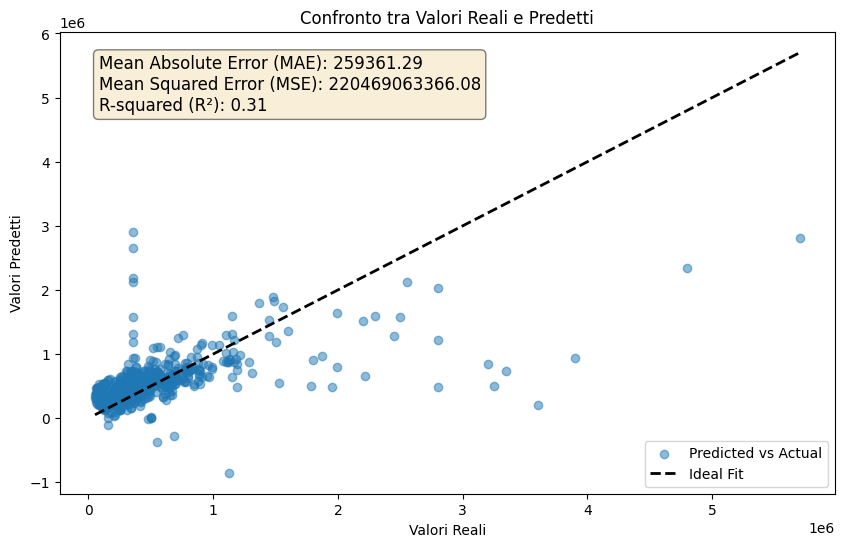

In [28]:
from sklearn.model_selection import train_test_split

# Ensure the columns specified in features exist in the dataframe
existing_features = [feature for feature in features if feature in df.columns]

X = df[existing_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.linear_model import LinearRegression

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

import matplotlib.pyplot as plt

# Grafico di confronto tra i valori reali e i valori predetti
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Confronto tra Valori Reali e Predetti')

# Aggiungi una legenda con le metriche di valutazione
mae_text = f"Mean Absolute Error (MAE): {mae:.2f}"
mse_text = f"Mean Squared Error (MSE): {mse:.2f}"
r2_text = f"R-squared (R²): {r2:.2f}"

# Create a box with the stats
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = '\n'.join((mae_text, mse_text, r2_text))

# Place the box in the upper left
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', bbox=props)

plt.legend()
plt.show()

features = ['number_rooms', 'area_m2', 'bathrooms', 'floor_number', 'condominium fees',
            'year of construction', 'Energy Efficiency']

            ccolonne_ohe = ['heating']
            colonne_frequency = ['Energy Efficiency', 'neighborhood']

/var/folders/zl/h8y9h0pj3c3cdg2k47s2plw00000gn/T/ipykernel_24920/2566287450.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda s: s.lower() if type(s) == str else s)
/var/folders/zl/h8y9h0pj3c3cdg2k47s2plw00000gn/T/ipykernel_24920/2566287450.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[colonna_da_modificare].fillna(mediana_price_euro, inplace=True)
/var/folders/zl/h8y9h0pj3c3cdg2k47s2plw00000gn/T/ipykernel_24920/2566287450.py:54: FutureWarning: A value i

Mean Absolute Error (MAE): 263713.55394082837
Mean Squared Error (MSE): 215641487365.14844
R-squared (R²): 0.3288758094137102


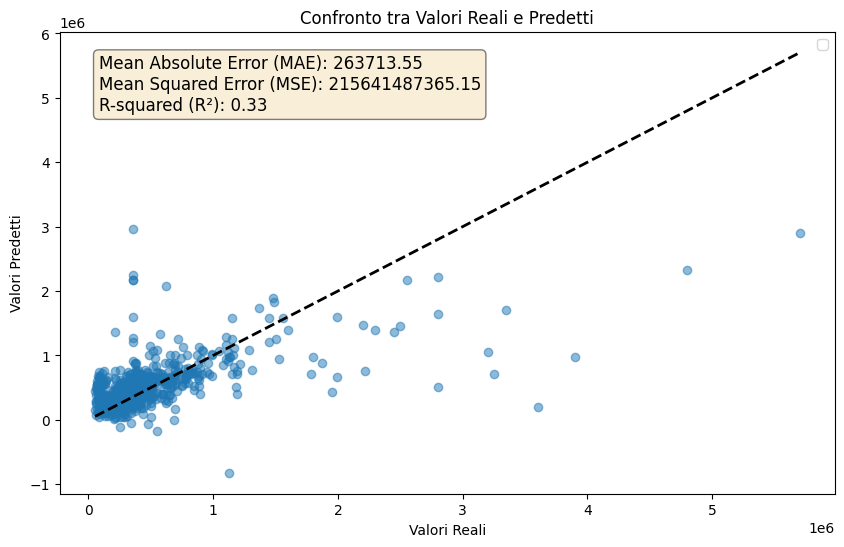

In [29]:
import pandas as pd
df= pd.read_csv("/Users/alessandrobragato//0_milan_real_estate/milano_house_prices_cleaned_data.csv")
# Converti tutti i valori testuali in minuscolo
df = df.applymap(lambda s: s.lower() if type(s) == str else s)
colonne_da_mantenere = ['area_m2','number_rooms','bathrooms', 
                        'floor_number', 'total building floors', 
                        'condominium fees', 'year of construction','condition', 
                        'heating', 'Air conditioner','Energy Efficiency',
                        'neighborhood', 'street', 'price_euro']


# Ottieni l'elenco di tutte le colonne nel DataFrame originale
tutte_le_colonne = df.columns

# Calcola le colonne da eliminare (quelle non incluse in colonne_da_mantenere)
colonne_da_eliminare = [colonna for colonna in tutte_le_colonne if colonna not in colonne_da_mantenere]

# Elimina le colonne non desiderate
df = df.drop(colonne_da_eliminare, axis=1)
# Colonna da modificare
colonna_da_modificare = 'price_euro'

# Rimuovi le parole specifiche dalla colonna di tipo oggetto
df[colonna_da_modificare] = df[colonna_da_modificare].str.replace('€', '', regex=False)
df[colonna_da_modificare] = df[colonna_da_modificare].str.replace('from', '', regex=False)
df[colonna_da_modificare] = df[colonna_da_modificare].str.replace('Price on application', '', regex=False)
df[colonna_da_modificare] = df[colonna_da_modificare].str.replace(',', '', regex=False)
# Converti la colonna in valori numerici, forzando i valori non numerici a NaN
df[colonna_da_modificare] = pd.to_numeric(df[colonna_da_modificare], errors='coerce')
# Calcola la mediana della colonna ignorando i valori NaN
mediana_price_euro = df[colonna_da_modificare].median()
# Riempi i valori NaN con la mediana calcolata
df[colonna_da_modificare].fillna(mediana_price_euro, inplace=True)

# Converti la colonna 'area_m2' in stringa
df['area_m2'] = df['area_m2'].astype(str)
# Rimuovi il testo "m²" dalla colonna 'area_m2'
df['area_m2'] = df['area_m2'].str.replace('m²', '', regex=False)
# Converti la colonna 'area_m2' in valori numerici, forzando i valori non numerici a NaN
df['area_m2'] = pd.to_numeric(df['area_m2'], errors='coerce')
# Calcola la mediana della colonna 'area_m2' ignorando i valori NaN
mediana_area = df['area_m2'].median()
# Calcola il primo e il terzo quartile per 'area_m2'
Q1_area = df['area_m2'].quantile(0.25)
Q3_area = df['area_m2'].quantile(0.75)
# Calcola l'intervallo interquartile (IQR) per 'area_m2'
IQR_area = Q3_area - Q1_area
# Definisci i limiti per identificare gli outlier per la colonna 'area_m2'
lower_bound_area = Q1_area - 1.5 * IQR_area
upper_bound_area = Q3_area + 1.5 * IQR_area
# Sostituisci gli outlier con la mediana
df.loc[(df['area_m2'] < lower_bound_area) | (df['area_m2'] > upper_bound_area), 'area_m2'] = mediana_area
# Riempi i valori NaN con la mediana calcolata
df['area_m2'].fillna(mediana_area, inplace=True)
# Definisci la colonna da modificare
colonna_da_modificare = 'area_m2'
# Converti la colonna in valori numerici, forzando i valori non numerici a NaN
df[colonna_da_modificare] = pd.to_numeric(df[colonna_da_modificare], errors='coerce')
# Calcola la mediana della colonna ignorando i valori NaN
mediana_area = df[colonna_da_modificare].median()

# Sostituisci i valori al di sotto di 19 con la mediana
df.loc[df[colonna_da_modificare] < 19, colonna_da_modificare] = mediana_area
colonna_originale = df['number_rooms'].copy()
# Converti la colonna 'number_rooms' in stringa
df['number_rooms'] = df['number_rooms'].astype(str)
# Rimuovi il testo ",m²" e "m²" dalla colonna 'number_rooms'
df['number_rooms'] = df['number_rooms'].str.replace('m²', '', regex=False)
# Converti la colonna 'number_rooms' in valori numerici, forzando i valori non numerici a NaN
df['number_rooms'] = pd.to_numeric(df['number_rooms'], errors='coerce')
# Calcola la mediana della colonna 'number_rooms' ignorando i valori NaN
mediana_rooms = df['number_rooms'].median()
# Riempi i valori NaN e i valori originariamente stringa con la mediana calcolata
df['number_rooms'].fillna(mediana_rooms, inplace=True)
df.loc[colonna_originale.isin(df['number_rooms'].astype(str)), 'number_rooms'] = mediana_rooms

# Converti la colonna 'bathrooms' in stringa
df['bathrooms'] = df['bathrooms'].astype(str)
# Rimuovi il testo "m²" dalla colonna 'bathrooms'
df['bathrooms'] = df['bathrooms'].str.replace('m²', '', regex=False)
# Converti la colonna 'bathrooms' in valori numerici, forzando i valori non numerici a NaN
df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')
# Calcola la mediana della colonna 'bathrooms' ignorando i valori NaN
mediana_bathrooms = df['bathrooms'].median()
# Riempi i valori NaN con la mediana calcolata
df['bathrooms'].fillna(mediana_bathrooms, inplace=True)

df['floor_number'] = df['floor_number'].astype(str)
# Rimuovi il testo "m²" dalla colonna 'floor_number'
df['floor_number'] = df['floor_number'].str.replace('m²', '', regex=False)
# Converti la colonna 'floor_number' in valori numerici, forzando i valori non numerici a NaN
df['floor_number'] = pd.to_numeric(df['floor_number'], errors='coerce')
# Calcola la mediana della colonna 'floor_number' ignorando i valori NaN
mediana_floor_number = df['floor_number'].median()
# Riempi i valori NaN con la mediana calcolata
df['floor_number'].fillna(mediana_floor_number, inplace=True)
# Sostituisci i valori vuoti con la mediana calcolata
df['floor_number'] = df['floor_number'].replace('NaN', mediana_floor_number)

# Calcola la mediana della colonna 'year of construction' ignorando i valori NaN
mediana_year_of_construction = df['year of construction'].median()
# Sostituisci i valori NaN e i valori vuoti con la mediana calcolata
df['year of construction'].fillna(mediana_year_of_construction, inplace=True)
df['year of construction'] = df['year of construction'].replace(' ', mediana_year_of_construction)

# Converti la colonna 'total building floors' in stringa
df['total building floors'] = df['total building floors'].astype(str)
# Rimuovi il testo " floors" dalla colonna 'total building floors'
df['total building floors'] = df['total building floors'].str.replace(' floors', '', regex=False)
# Converti la colonna 'total building floors' in valori numerici, forzando i valori non numerici a NaN
df['total building floors'] = pd.to_numeric(df['total building floors'], errors='coerce')
# Riempi i valori NaN con la mediana calcolata
mediana_total_building_floors = df['total building floors'].median()
df['total building floors'].fillna(mediana_total_building_floors, inplace=True)
# Sostituisci i valori vuoti con la mediana calcolata
df['total building floors'] = df['total building floors'].replace(' ', mediana_total_building_floors)

colonna_da_modificare2 = 'condominium fees'
# Converti la colonna in stringa
df[colonna_da_modificare2] = df[colonna_da_modificare2].astype(str)
# Rimuovi i caratteri non numerici e parti di testo specifici
df[colonna_da_modificare2] = df[colonna_da_modificare2].str.replace('€', '', regex=False)
df[colonna_da_modificare2] = df[colonna_da_modificare2].str.replace('/mese', '', regex=False)
df[colonna_da_modificare2] = df[colonna_da_modificare2].str.replace('/month', '', regex=False)
# Sostituisci 'No condominium fees' e 'nan' con NaN
df[colonna_da_modificare2] = df[colonna_da_modificare2].replace(['No condominium fees', 'nan'], pd.NA)
# Converti la colonna in valori numerici, forzando i valori non numerici a NaN
df[colonna_da_modificare2] = pd.to_numeric(df[colonna_da_modificare2], errors='coerce')
# Calcola la mediana della colonna 'condominium fees' ignorando i valori NaN
mediana_condominium_fees = df[colonna_da_modificare2].median()
# Riempi i valori NaN con la mediana calcolata
df[colonna_da_modificare2].fillna(mediana_condominium_fees, inplace=True)

# Definisci le colonne per le quali vuoi applicare l'OHE
colonne_ohe = ['heating']
# Applica OHE alle colonne specificate
df = pd.get_dummies(df, columns=colonne_ohe, drop_first=True)
#applico Frequency encoding
colonne_frequency = ['Energy Efficiency', 'neighborhood']
# Per ogni colonna nell'elenco
for colonna in colonne_frequency:
    # Gestione dei valori NaN
    modalità = df[colonna].mode()[0]
    df[colonna].fillna(modalità, inplace=True)
     # Calcola la frequenza di ogni valore categorico
    frequenze = df[colonna].value_counts(normalize=True)
    # Sostituisci i valori categorici con le frequenze
    df[colonna] = df[colonna].map(frequenze)
# Seleziona le caratteristiche (features) e la variabile target
features = ['number_rooms', 'area_m2', 'bathrooms', 'floor_number', 'condominium fees',
            'year of construction', 'Energy Efficiency']
features += [col for col in df.columns if col.startswith('heating_')]

target = 'price_euro'

# Preprocess 'Energy Efficiency' column
df['Energy Efficiency'] = df['Energy Efficiency'].astype(str).str.extract('(\d+\.?\d*)')
df['Energy Efficiency'] = pd.to_numeric(df['Energy Efficiency'], errors='coerce')
# Fill NaN values with the median of the column
df['Energy Efficiency'].fillna(df['Energy Efficiency'].median(), inplace=True)

# Drop NaN values in the target column
df = df.dropna(subset=[target])

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a linear regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

# Plot the comparison between actual and predicted values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Confronto tra Valori Reali e Predetti')

# Aggiungi una legenda con le metriche di valutazione
mae_text = f"Mean Absolute Error (MAE): {mae:.2f}"
mse_text = f"Mean Squared Error (MSE): {mse:.2f}"
r2_text = f"R-squared (R²): {r2:.2f}"

# Create a box with the stats
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = '\n'.join((mae_text, mse_text, r2_text))

# Place the box in the upper left
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', bbox=props)

plt.legend()
plt.show()


Il risultato non era comunque ottimale, anzi poco migliore ma avevo oltre a questo avevo il problema che non saprevo come inserire nuovi dati per testare la bontà del modello, per via degli encoding che forniscono dati numerici rispetto a quelli testuali, il problema che non sapevo a che luogo corrispondessero tali numeri e andare a cercarli uno per uno non mi sembrava una soluzione ottimale

Allora abbiamo deciso di diminuire ancora il numero di variabili e, siccome avremmo dovuto provare la bontà di predizione del prezzo non sapevamo come inserire un nuovo dato per via degli encoding, di conseguenza abbiamo fatti degli encoding manuali per le categorie “Energy Efficency”, da A+++(0) a G (9)  “heating” (centralizzato 0 / indipendente 1) “condition”da 0 a 3 e abbiamo estratto le coordinate dei punti del dataset tenendo in considerazione la città la via e il vicinato, un volta fatto ciò abbiamo suddiviso i dati delle coorindate in una griglia equamente suddivisa in 7x7 che ha come massimo e minimo delle coordinate approssimative della città di milano. Ad ogni cella sono stati associati dei valori numerici da 1 a 49 per poter poi inserire i nuovi record

ho installato geopandas e geopy –>pip install geopandas geopy (nel venev)

In [30]:
colonne_da_mantenere = ['neighborhood']
# Ottieni l'elenco di tutte le colonne nel DataFrame originale
tutte_le_colonne = df.columns
# Calcola le colonne da eliminare (quelle non incluse in colonne_da_mantenere)
colonne_da_eliminare = [colonna for colonna in tutte_le_colonne if colonna not in colonne_da_mantenere]
# Elimina le colonne non desiderate
df = df.drop(colonne_da_eliminare, axis=1)

def get_coordinates(address):
    """
    Ottiene le coordinate di latitudine e longitudine per un indirizzo.
    
    Args:
        address (str): L'indirizzo da geocodificare.
        
    Returns:
        tuple: Una tupla contenente la latitudine e la longitudine.
    """
    geolocator = geopy.Nominatim(user_agent="my_app")
    location = geolocator.geocode(address)
    if location is None:
        return None, None
    return location.latitude, location.longitude

In [31]:
%pip install geopy 
%pip install geopandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [33]:

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import geopy
import time

# Funzione per ottenere le coordinate di latitudine e longitudine per un indirizzo
def get_coordinates(address):
    geolocator = geopy.Nominatim(user_agent="my_app")
    location = geolocator.geocode(address)
    if location is None:
        return None, None
    return location.latitude, location.longitude

# Funzione per ottenere le coordinate con gestione dei timeout
def get_coordinates_with_retry(address, retries=3, delay=2):
    for i in range(retries):
        try:
            return get_coordinates(address)
        except (geopy.exc.GeocoderTimedOut, geopy.exc.GeocoderUnavailable, geopy.exc.GeocoderServiceError):
            if i < retries - 1:
                time.sleep(delay)
            else:
                return None, None

# Carica il DataFrame
df = pd.read_csv("/Users/alessandrobragato//0_milan_real_estate/milano_house_prices_cleaned_data.csv")

# Aggiungi colonne per latitudine e longitudine
df['latitudine'] = None
df['longitudine'] = None

# Limiti delle coordinate
lat_min, lat_max = 45.4318, 45.5048
lon_min, lon_max = 9.1279, 9.2513

# Applica il geocoding a ogni record e popola le nuove colonne
for index, row in df.iterrows():
    address = f"{row['street']}, {row['city']}"
    latitude, longitude = get_coordinates_with_retry(address)
    if latitude is None or longitude is None:
        address = f"{row['neighborhood']}, {row['city']}"
        latitude, longitude = get_coordinates_with_retry(address)
    
    # Check if coordinates are within the acceptable range
    if latitude is not None and longitude is not None:
        if not (lat_min <= latitude <= lat_max and lon_min <= longitude <= lon_max):
            latitude = random.uniform(lat_min, lat_max)
            longitude = random.uniform(lon_min, lon_max)
    else:
        latitude = random.uniform(lat_min, lat_max)
        longitude = random.uniform(lon_min, lon_max)
    
    df.at[index, 'latitudine'] = latitude
    df.at[index, 'longitudine'] = longitude

# Visualizza i primi record per verificare
df.head()

,Unnamed: 0,price_euro,number_rooms,area_m2,bathrooms,floor_number,description,Reference and listing Date,contract,type,...,condition,heating,Air conditioner,Energy Efficiency,city,neighborhood,street,URL,latitudine,longitudine
0,0,"€ 289,000",3,100m²,1,4,Si propone in vendita in esclusiva un ampio ap...,CNB6 - 10/24/2023,Sale,Apartment | Full ownership | Stately property ...,...,Good condition / Liveable,"Central, with radiators, powered by methane","Central, cold",F≥ 175 kWh/m² year,Milan,Baggio,Via Val Cannobina,https://www.immobiliare.it/en/annunci/106903681/,45.473053,9.133777
1,1,"€ 950,000",234m²,3,5,NaN,A few steps from numerous neighborhood service...,LU.P5.R6_533 - 10/24/2023,Sale,Apartment | Full ownership | Stately property ...,...,Excellent / Refurbished,"Independent, with radiators, gas powered","Independent, cold",E120 kWh/m² year,Milan,Ponte Nuovo,Via del Ricordo,https://www.immobiliare.it/en/annunci/106886279/,45.488175,9.215958
2,2,"€ 398,000",2,78m²,1,2,"RIF: Divina Servizi Immobiliari di Seregno, Pi...",EK-106888689 - 10/24/2023,Sale,Apartment | Full ownership | Stately property ...,...,Good condition / Liveable,"Central, with radiators, gas powered",NaN,F232.6 kWh/m² year,Milan,Argonne - Corsica,Via Druso,https://www.immobiliare.it/en/annunci/106888689/,45.466061,9.231666
3,3,"€ 420,000",3,85m²,1,2,Zona Crescenzago e più precisamente in Via Pri...,CS- Vittorelli - 10/24/2023,Sale,Apartment | Full ownership | Stately property ...,...,Excellent / Refurbished,"Central, floor heating, gas powered",System predisposition,"A1≥ 3,51 kWh/m² year",Milan,Crescenzago,Via Jacopo Vittorelli,https://www.immobiliare.it/en/annunci/106892137/,45.4701,9.150007
4,4,"€ 780,000",3,80m²,1,5,Ref: ST6 - Tempocasa in Via Bergamo 11 offers ...,ST6 - 10/24/2023,Sale,Apartment | Full ownership | Stately property ...,...,Excellent / Refurbished,"Independent, with radiators, powered by methane","Independent, cold",E109 kWh/m² year,Milan,Porta Romana - Medaglie d'Oro,Via Gerolamo Tiraboschi 6,https://www.immobiliare.it/en/annunci/106889543/,45.452528,9.209049


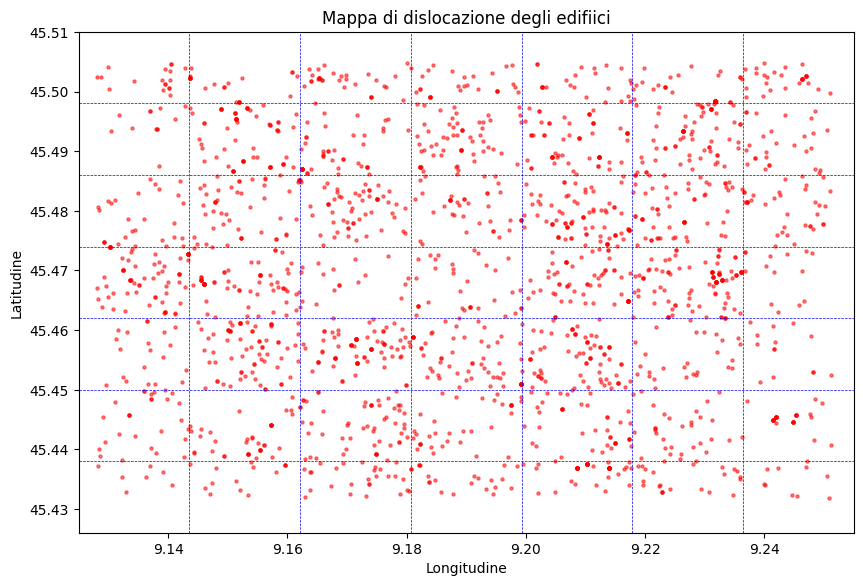

     latitudine longitudine grid_cell
0     45.473053    9.133777       4,1
1     45.488175    9.215958       6,5
2     45.466061    9.231666       4,6
3       45.4701    9.150007       4,2
4     45.452528    9.209049       3,5
...         ...         ...       ...
1995  45.448126    9.199132       2,4
1996  45.449255    9.137117       2,1
1997  45.450931    9.199199       3,4
1998  45.489041    9.204405       6,5
1999   45.45261     9.22798       3,6

[2000 rows x 3 columns]


In [34]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt

# Supponiamo che il DataFrame df sia già stato definito e contenga le colonne 'latitudine' e 'longitudine'

# Rimuovi duplicati
df = df.drop_duplicates()

# Rimuovi i record con valori None nelle colonne 'latitudine' e 'longitudine'
df = df.dropna(subset=['latitudine', 'longitudine'])

# Definisci i limiti della griglia
lat_min = 45.4260
lat_max = 45.5100
lon_min = 9.1250
lon_max = 9.2550

# Definisci il numero di celle della griglia
n_cells_lat = 7
n_cells_lon = 7

# Crea la griglia
lat_bins = np.linspace(lat_min, lat_max, n_cells_lat + 1)
lon_bins = np.linspace(lon_min, lon_max, n_cells_lon + 1)

# Assegna ogni record a una cella della griglia
df['lat_bin'] = np.digitize(df['latitudine'], lat_bins)
df['lon_bin'] = np.digitize(df['longitudine'], lon_bins)

# Crea un'etichetta unica per ogni cella della griglia
df['grid_cell'] = df['lat_bin'].astype(str) + ',' + df['lon_bin'].astype(str)

# Crea un GeoDataFrame
geometry = [Point(xy) for xy in zip(df['longitudine'], df['latitudine'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Crea la figura e gli assi
fig, ax = plt.subplots(figsize=(10, 10))

# Traccia i punti
gdf.plot(ax=ax, marker='o', color='red', markersize=5, alpha=0.5)

# Traccia la griglia
for lat in lat_bins:
    plt.axhline(y=lat, color='blue', linestyle='--', linewidth=0.5)
for lon in lon_bins:
    plt.axvline(x=lon, color='blue', linestyle='--', linewidth=0.5)

# Imposta i limiti della mappa
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

# Aggiungi etichette e titolo
plt.xlabel('Longitudine')
plt.ylabel('Latitudine')
plt.title('Mappa di dislocazione degli edifiici')

# Mostra la mappa
plt.show()

# Visualizza il DataFrame con le nuove colonne
print(df[['latitudine', 'longitudine', 'grid_cell']])

grid_cell
4,6    104
5,5     82
3,3     79
3,5     73
6,6     72
3,2     71
4,1     70
3,4     65
4,2     65
6,2     64
6,5     61
4,5     60
6,4     60
5,3     57
2,3     56
5,6     56
5,2     51
1,5     47
6,3     44
2,5     43
2,2     40
5,4     39
5,7     36
2,4     35
4,4     34
2,6     33
7,3     33
7,6     30
7,7     29
2,7     29
5,1     28
6,7     28
1,3     27
2,1     27
7,4     27
3,6     27
7,5     24
1,4     22
7,2     22
1,6     22
3,1     21
4,3     18
7,1     18
1,2     14
3,7     14
4,7     14
6,1     12
1,7     10
1,1      7
Name: count, dtype: int64
grid_cell
4,6    5.20
5,5    4.10
3,3    3.95
3,5    3.65
6,6    3.60
3,2    3.55
4,1    3.50
3,4    3.25
4,2    3.25
6,2    3.20
6,5    3.05
4,5    3.00
6,4    3.00
5,3    2.85
2,3    2.80
5,6    2.80
5,2    2.55
1,5    2.35
6,3    2.20
2,5    2.15
2,2    2.00
5,4    1.95
5,7    1.80
2,4    1.75
4,4    1.70
2,6    1.65
7,3    1.65
7,6    1.50
7,7    1.45
2,7    1.45
5,1    1.40
6,7    1.40
1,3    1.35
2,1    1.35
7,4    

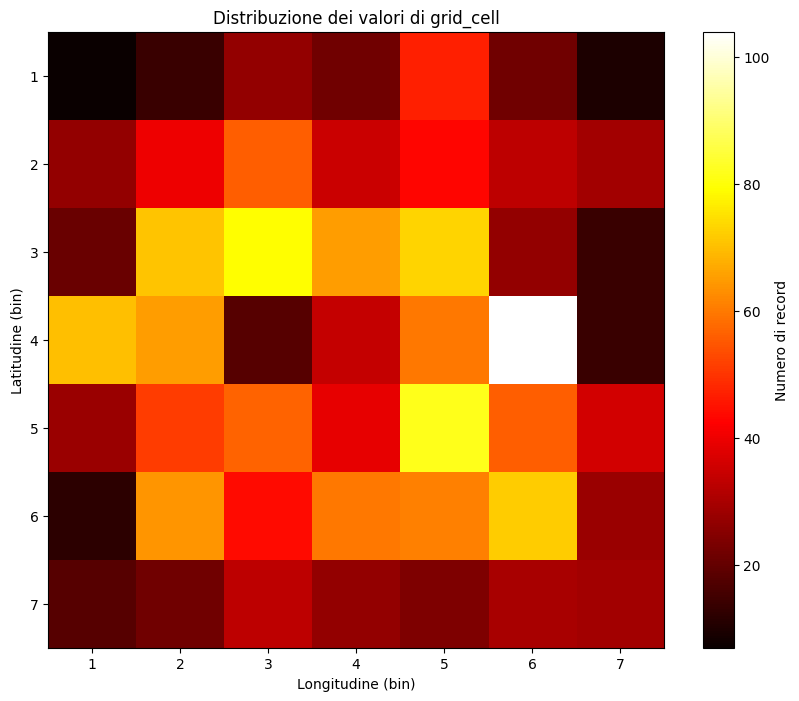

In [35]:
# Ottieni i valori distinti di 'grid_cell' e il numero di volte che si ripetono
grid_cell_counts = df['grid_cell'].value_counts()

# Visualizza i risultati
print(grid_cell_counts)

# Visualizza la distribuzione dei valori di 'grid_cell'
grid_cell_distribution = df['grid_cell'].value_counts(normalize=True) * 100
print(grid_cell_distribution)
# Crea una mappa di calore per visualizzare la distribuzione di 'grid_cell'
heatmap_data = np.zeros((n_cells_lat, n_cells_lon))

for i in range(n_cells_lat):
    for j in range(n_cells_lon):
        cell_label = f"{i+1},{j+1}"
        if cell_label in grid_cell_counts:
            heatmap_data[i, j] = grid_cell_counts[cell_label]

plt.figure(figsize=(10, 8))
plt.imshow(heatmap_data, cmap='hot', interpolation='nearest')
plt.colorbar(label='Numero di record')
plt.title('Distribuzione dei valori di grid_cell')
plt.xlabel('Longitudine (bin)')
plt.ylabel('Latitudine (bin)')
plt.xticks(ticks=np.arange(n_cells_lon), labels=np.arange(1, n_cells_lon + 1))
plt.yticks(ticks=np.arange(n_cells_lat), labels=np.arange(1, n_cells_lat + 1))
plt.show()

In [37]:
#controllo che i valori fossero distribuiti in modo equo e non avesse preso solo 'milano' 
# inizialemnte l'etrazione aveva più di 1k nello stesso punto appunto 'milano'
#4,6 è la coppia di valori della griglia con il maggior numero di valori e il primo numero 4 sta a latitudine il secondo numero 6 sta a longitudine
max_grid_cell = grid_cell_counts.idxmax()
max_count = grid_cell_counts.max()
print(f"La coppia di valori della griglia con il maggior numero di valori è {max_grid_cell} con {max_count} valori.")

La coppia di valori della griglia con il maggior numero di valori è 4,6 con 104 valori.


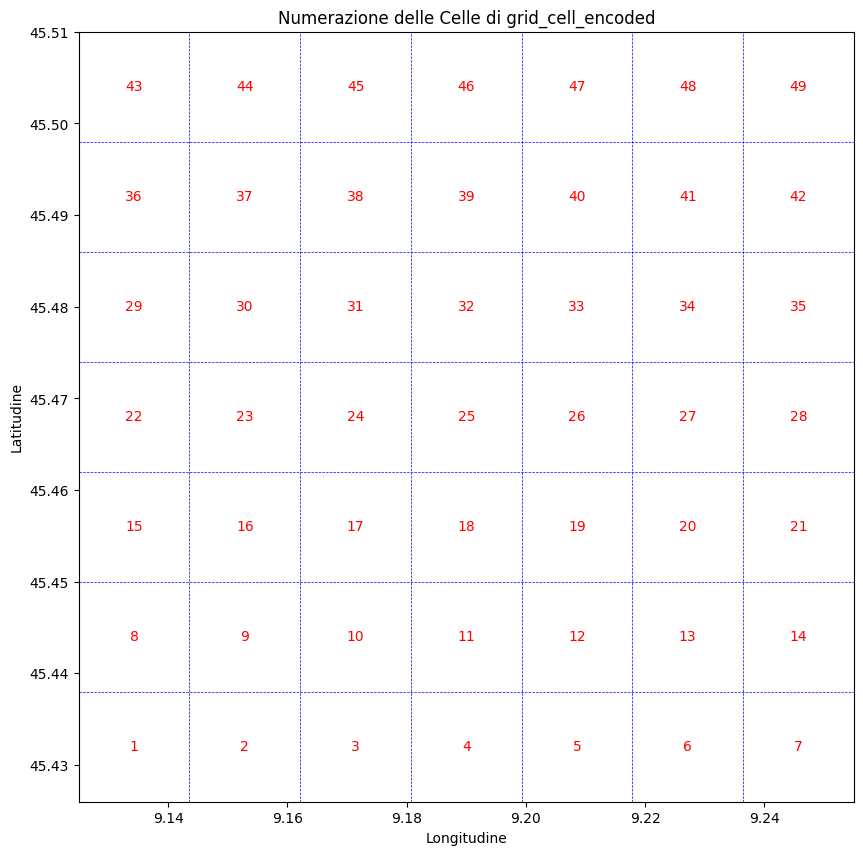

In [38]:
#enumerazione delle celle
import matplotlib.pyplot as plt
import numpy as np

# Crea una mappa di grid_cell_encoded
grid_cell_mapping = {f"{i},{j}": (i - 1) * 7 + j for i in range(1, 8) for j in range(1, 8)}

# Definisci i limiti della griglia
lat_min = 45.4260
lat_max = 45.5100
lon_min = 9.1250
lon_max = 9.2550

# Definisci il numero di celle della griglia
n_cells_lat = 7
n_cells_lon = 7

# Crea la griglia
lat_bins = np.linspace(lat_min, lat_max, n_cells_lat + 1)
lon_bins = np.linspace(lon_min, lon_max, n_cells_lon + 1)

# Crea la figura e gli assi
fig, ax = plt.subplots(figsize=(10, 10))

# Traccia la griglia
for lat in lat_bins:
    plt.axhline(y=lat, color='blue', linestyle='--', linewidth=0.5)
for lon in lon_bins:
    plt.axvline(x=lon, color='blue', linestyle='--', linewidth=0.5)

# Aggiungi etichette per ogni cella della griglia
for i in range(1, n_cells_lat + 1):
    for j in range(1, n_cells_lon + 1):
        cell_label = f"{i},{j}"
        cell_number = grid_cell_mapping[cell_label]
        lat_center = (lat_bins[i-1] + lat_bins[i]) / 2
        lon_center = (lon_bins[j-1] + lon_bins[j]) / 2
        plt.text(lon_center, lat_center, str(cell_number), color='red', ha='center', va='center')

# Imposta i limiti della mappa
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

# Aggiungi etichette e titolo
plt.xlabel('Longitudine')
plt.ylabel('Latitudine')
plt.title('Numerazione delle Celle di grid_cell_encoded')

# Mostra la mappa
plt.show()

***pulizia e pretrattamento più manual encoding***

In [44]:
#pulizia Energy Efficency
import re

# Funzione per estrarre solo le lettere dalla colonna Energy Efficiency
def extract_energy_efficiency(value):
    if pd.isna(value):
        return value
    value = re.sub(r'kWhmyear', '', value)
    value = re.sub(r'almostzeroenergybuilding', 'F', value)
    return ''.join(re.findall('[A-Za-z+]+', value))

# Applica la funzione alla colonna Energy Efficiency
df['Energy Efficiency'] = df['Energy Efficiency'].apply(extract_energy_efficiency)

# Funzione per riempire i valori mancanti
def fill_missing_energy_efficiency(row):
    if pd.isna(row['Energy Efficiency']):
        year = row['year of construction']
        condition = row['condition']
        
        if not pd.isna(year):
            # Filtra il DataFrame per l'intervallo di anni
            mask = (df['year of construction'] >= year - 5) & (df['year of construction'] <= year + 5)
            mode_value = df.loc[mask, 'Energy Efficiency'].mode()
            if not mode_value.empty:
                return mode_value.iloc[0]
        
        if not pd.isna(condition):
            # Filtra il DataFrame per la condizione di costruzione
            mask = df['condition'] == condition
            mode_value = df.loc[mask, 'Energy Efficiency'].mode()
            if not mode_value.empty:
                return mode_value.iloc[0]
        
        # Se nessuna delle due informazioni è disponibile, riempi con il valore mediano
        return df['Energy Efficiency'].mode().iloc[0]
    
    return row['Energy Efficiency']

# Applica la funzione al DataFrame
df['Energy Efficiency'] = df.apply(fill_missing_energy_efficiency, axis=1)
#prendo in considerazione soloa la prima lettera di Energy Efficency e droppo gli NaN
def simplify_energy_efficiency(value):
    if pd.isna(value):
        return value
    return value[0]  # Prendi solo la prima lettera

# Applica la funzione alla colonna 'Energy Efficiency'
df['Energy Efficiency'] = df['Energy Efficiency'].apply(simplify_energy_efficiency)

# Visualizza i primi record per verificare
df.head(1)

,Unnamed: 0,price_euro,number_rooms,area_m2,bathrooms,floor_number,description,Reference and listing Date,contract,type,...,Energy Efficiency,city,neighborhood,street,URL,latitudine,longitudine,lat_bin,lon_bin,grid_cell
0,0,"€ 289,000",3,100m²,1,4,Si propone in vendita in esclusiva un ampio ap...,CNB6 - 10/24/2023,Sale,Apartment | Full ownership | Stately property ...,...,F,Milan,Baggio,Via Val Cannobina,https://www.immobiliare.it/en/annunci/106903681/,45.473053,9.133777,4,1,"4,1"


In [46]:
#Crea una mappatura dei valori testuali ai valori numerici
energy_efficiency_mapping = {
    'A+++': 0,
    'A++': 1,
    'A+': 2,
    'A': 3,
    'B': 4,
    'C': 5,
    'D': 6,
    'E': 7,
    'F': 8,
    'G': 9
}

# Applica la mappatura alla colonna 'Energy Efficiency'
df['Energy Efficiency Encoded'] = df['Energy Efficiency'].map(energy_efficiency_mapping)

# Visualizza i primi record per verificare
df.head(1)

,Unnamed: 0,price_euro,number_rooms,area_m2,bathrooms,floor_number,description,Reference and listing Date,contract,type,...,neighborhood,street,URL,latitudine,longitudine,lat_bin,lon_bin,grid_cell,grid_cell_encoded,Energy Efficiency Encoded
0,0,"€ 289,000",3,100m²,1,4,Si propone in vendita in esclusiva un ampio ap...,CNB6 - 10/24/2023,Sale,Apartment | Full ownership | Stately property ...,...,Baggio,Via Val Cannobina,https://www.immobiliare.it/en/annunci/106903681/,45.473053,9.133777,4,1,"4,1",22,8


In [45]:
# Crea un dizionario di mappatura per grid_cell
grid_cell_mapping = {f"{i},{j}": (i - 1) * 7 + j for i in range(1, 8) for j in range(1, 8)}

# Applica la mappatura alla colonna grid_cell
df['grid_cell_encoded'] = df['grid_cell'].map(grid_cell_mapping)



# Visualizza i primi record per verificare
df.head(1)

,Unnamed: 0,price_euro,number_rooms,area_m2,bathrooms,floor_number,description,Reference and listing Date,contract,type,...,city,neighborhood,street,URL,latitudine,longitudine,lat_bin,lon_bin,grid_cell,grid_cell_encoded
0,0,"€ 289,000",3,100m²,1,4,Si propone in vendita in esclusiva un ampio ap...,CNB6 - 10/24/2023,Sale,Apartment | Full ownership | Stately property ...,...,Milan,Baggio,Via Val Cannobina,https://www.immobiliare.it/en/annunci/106903681/,45.473053,9.133777,4,1,"4,1",22


In [47]:
#pulizia e encoding di heating
import pandas as pd
import numpy as np

# Funzione per pulire la colonna "heating"
def clean_heating(value):
    if pd.isna(value):
        return value
    value = value.lower()
    if 'central' in value:
        return 'central'
    elif 'independent' in value:
        return 'independent'
    else:
        return np.nan

# Applica la funzione alla colonna "heating"
df['heating'] = df['heating'].apply(clean_heating)

# Funzione per riempire i valori mancanti in base alla relazione con "year of construction"
def fill_missing_heating(row):
    if pd.isna(row['heating']):
        year = row['year of construction']
        if not pd.isna(year):
            mask = (df['year of construction'] >= year - 5) & (df['year of construction'] <= year + 5)
            mode_value = df.loc[mask, 'heating'].mode()
            if not mode_value.empty:
                return mode_value.iloc[0]
        return df['heating'].mode().iloc[0]
    return row['heating']

# Applica la funzione al DataFrame
df['heating'] = df.apply(fill_missing_heating, axis=1)

# Effettua l'encoding
heating_mapping = {'central': 0, 'independent': 1}
df['heating_encoded'] = df['heating'].map(heating_mapping)

# Visualizza i primi record per verificare
df.head(1)

,Unnamed: 0,price_euro,number_rooms,area_m2,bathrooms,floor_number,description,Reference and listing Date,contract,type,...,street,URL,latitudine,longitudine,lat_bin,lon_bin,grid_cell,grid_cell_encoded,Energy Efficiency Encoded,heating_encoded
0,0,"€ 289,000",3,100m²,1,4,Si propone in vendita in esclusiva un ampio ap...,CNB6 - 10/24/2023,Sale,Apartment | Full ownership | Stately property ...,...,Via Val Cannobina,https://www.immobiliare.it/en/annunci/106903681/,45.473053,9.133777,4,1,"4,1",22,8,0


In [48]:
# Trasforma i valori "Open to participate" e "Not open to participation"
df['condition'] = df['condition'].replace({
	'Open to participate': 'Good condition / Liveable',
	'Not open to participation': 'Excellent / Refurbished'
})

# Sostituisci i valori NaN con il valore modale
mode_condition = df['condition'].mode()[0]
df['condition'] = df['condition'].fillna(mode_condition)

# Visualizza i valori unici per verificare
valori_unici_condition = df['condition'].unique()
print(valori_unici_condition)
# Crea un dizionario di mappatura per la colonna "condition"
condition_mapping = {
    'New / Under construction': 0,
    'Excellent / Refurbished': 1,
    'Good condition / Liveable': 2,
    'To be refurbished': 3
}

# Applica la mappatura alla colonna "condition"
df['condition_encoded'] = df['condition'].map(condition_mapping)

# Visualizza i primi record per verificare
df.head(1)

['Good condition / Liveable' 'Excellent / Refurbished' 'To be refurbished'
 'New / Under construction']


,Unnamed: 0,price_euro,number_rooms,area_m2,bathrooms,floor_number,description,Reference and listing Date,contract,type,...,URL,latitudine,longitudine,lat_bin,lon_bin,grid_cell,grid_cell_encoded,Energy Efficiency Encoded,heating_encoded,condition_encoded
0,0,"€ 289,000",3,100m²,1,4,Si propone in vendita in esclusiva un ampio ap...,CNB6 - 10/24/2023,Sale,Apartment | Full ownership | Stately property ...,...,https://www.immobiliare.it/en/annunci/106903681/,45.473053,9.133777,4,1,"4,1",22,8,0,2


In [ ]:
# Salva il nuovo dataset df1 nella directory specificata
#df.to_csv("/Users/alessandrobragato/0_real_estate_milan/df1.csv", index=False)

/var/folders/zl/h8y9h0pj3c3cdg2k47s2plw00000gn/T/ipykernel_24920/3306295778.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df1 = df1.applymap(lambda s: s.lower() if type(s) == str else s)
/var/folders/zl/h8y9h0pj3c3cdg2k47s2plw00000gn/T/ipykernel_24920/3306295778.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1[colonna_da_modificare].fillna(mediana_price_euro, inplace=True)
/var/folders/zl/h8y9h0pj3c3cdg2k47s2plw00000gn/T/ipykernel_24920/3306295778.py:59: FutureWarning: A valu

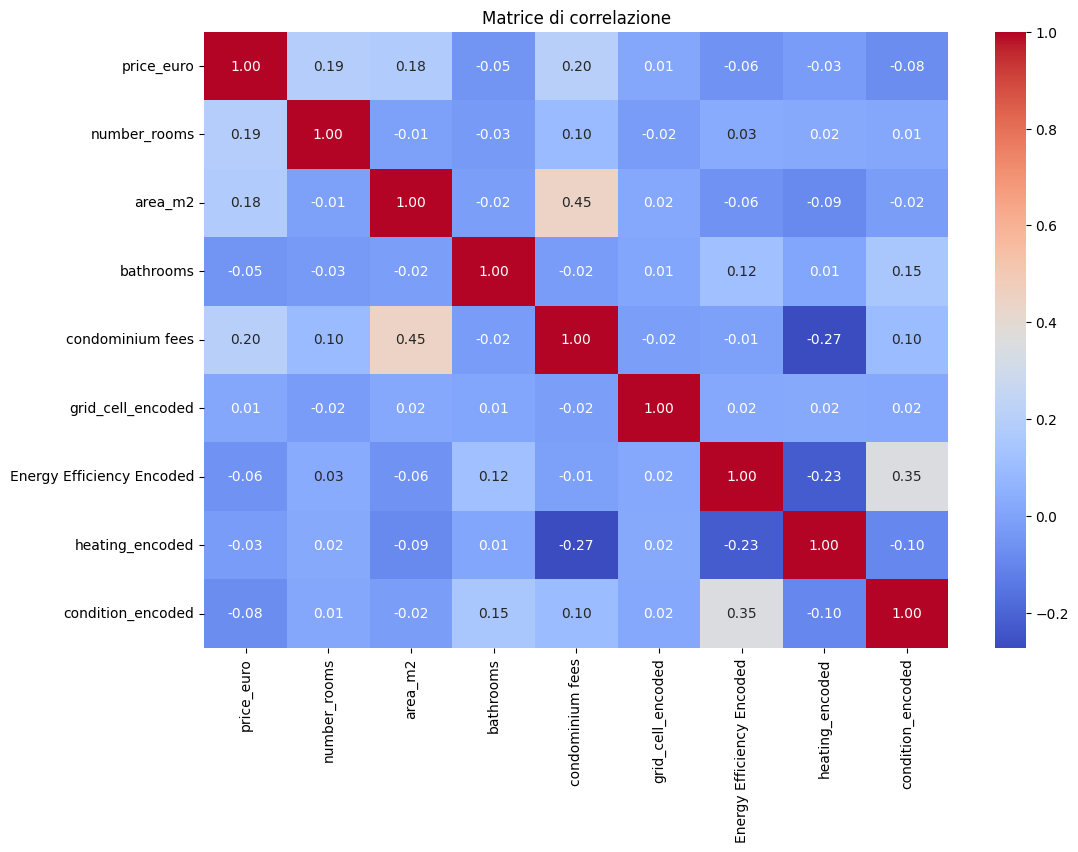

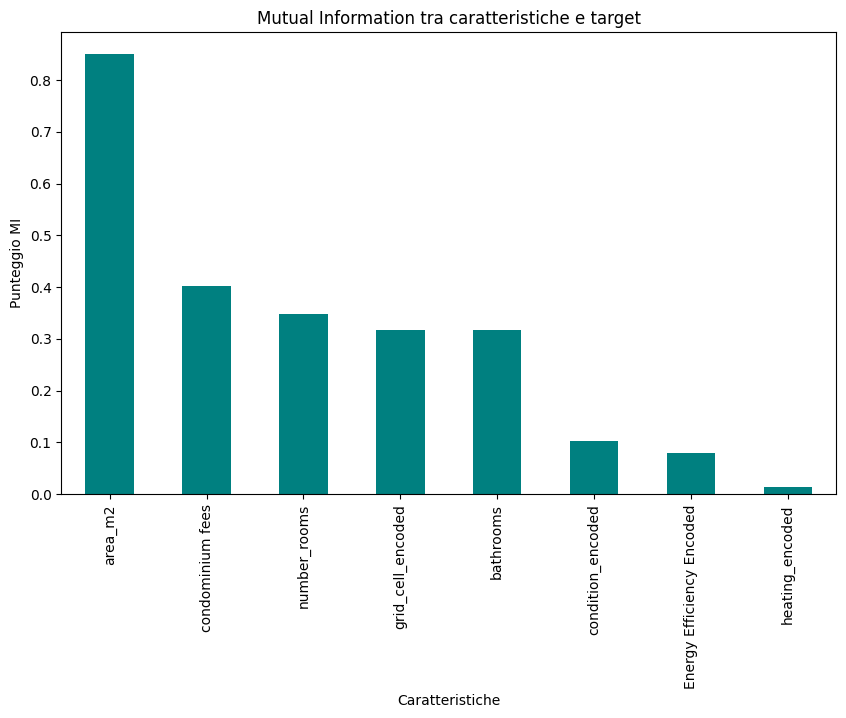

Punteggi di mutual information:
 area_m2                      0.849743
condominium fees             0.401923
number_rooms                 0.348899
grid_cell_encoded            0.317782
bathrooms                    0.317769
condition_encoded            0.102283
Energy Efficiency Encoded    0.079910
heating_encoded              0.014565
dtype: float64
Caratteristiche rimosse per bassa correlazione:
 Index([], dtype='object')


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

df1= pd.read_csv("/Users/alessandrobragato//0_milan_real_estate/df1.csv")
# Converti tutti i valori testuali in minuscolo
df1 = df1.applymap(lambda s: s.lower() if type(s) == str else s)
# Check if the columns exist in the DataFrame
colonne_da_mantenere = [col for col in ['area_m2','number_rooms','bathrooms', 'condominium fees', 
                        'condition_encoded', 'heating_encoded',
                        'Energy Efficiency Encoded','grid_cell_encoded',
                        'price_euro'] if col in df1.columns]


# Ottieni l'elenco di tutte le colonne nel DataFrame originale
tutte_le_colonne = df1.columns

# Calcola le colonne da eliminare (quelle non incluse in colonne_da_mantenere)
colonne_da_eliminare = [colonna for colonna in tutte_le_colonne if colonna not in colonne_da_mantenere]

# Elimina le colonne non desiderate
df1 = df1.drop(colonne_da_eliminare, axis=1)
# Colonna da modificare
colonna_da_modificare = 'price_euro'

# Rimuovi le parole specifiche dalla colonna di tipo oggetto
df1[colonna_da_modificare] = df1[colonna_da_modificare].str.replace('€', '', regex=False)
df1[colonna_da_modificare] = df1[colonna_da_modificare].str.replace('from', '', regex=False)
df1[colonna_da_modificare] = df1[colonna_da_modificare].str.replace('Price on application', '', regex=False)
df1[colonna_da_modificare] = df1[colonna_da_modificare].str.replace(',', '', regex=False)
# Converti la colonna in valori numerici, forzando i valori non numerici a NaN
df1[colonna_da_modificare] = pd.to_numeric(df1[colonna_da_modificare], errors='coerce')
# Calcola la mediana della colonna ignorando i valori NaN
mediana_price_euro = df1[colonna_da_modificare].median()
# Riempi i valori NaN con la mediana calcolata
df1[colonna_da_modificare].fillna(mediana_price_euro, inplace=True)

# Converti la colonna 'area_m2' in stringa
df1['area_m2'] = df1['area_m2'].astype(str)
# Rimuovi il testo "m²" dalla colonna 'area_m2'
df1['area_m2'] = df1['area_m2'].str.replace('m²', '', regex=False)
# Converti la colonna 'area_m2' in valori numerici, forzando i valori non numerici a NaN
df1['area_m2'] = pd.to_numeric(df1['area_m2'], errors='coerce')
# Calcola la mediana della colonna 'area_m2' ignorando i valori NaN
mediana_area = df1['area_m2'].median()
# Calcola il primo e il terzo quartile per 'area_m2'
Q1_area = df1['area_m2'].quantile(0.25)
Q3_area = df1['area_m2'].quantile(0.75)
# Calcola l'intervallo interquartile (IQR) per 'area_m2'
IQR_area = Q3_area - Q1_area
# Definisci i limiti per identificare gli outlier per la colonna 'area_m2'
lower_bound_area = Q1_area - 1.5 * IQR_area
upper_bound_area = Q3_area + 1.5 * IQR_area
# Sostituisci gli outlier con la mediana
df1.loc[(df1['area_m2'] < lower_bound_area) | (df1['area_m2'] > upper_bound_area), 'area_m2'] = mediana_area
# Riempi i valori NaN con la mediana calcolata
df1['area_m2'].fillna(mediana_area, inplace=True)
# Definisci la colonna da modificare
colonna_da_modificare = 'area_m2'
# Converti la colonna in valori numerici, forzando i valori non numerici a NaN
df1[colonna_da_modificare] = pd.to_numeric(df1[colonna_da_modificare], errors='coerce')
# Calcola la mediana della colonna ignorando i valori NaN
mediana_area = df1[colonna_da_modificare].median()

# Sostituisci i valori al di sotto di 19 con la mediana
df1.loc[df1[colonna_da_modificare] < 19, colonna_da_modificare] = mediana_area
colonna_originale = df1['number_rooms'].copy()
# Converti la colonna 'number_rooms' in stringa
df1['number_rooms'] = df1['number_rooms'].astype(str)
# Rimuovi il testo ",m²" e "m²" dalla colonna 'number_rooms'
df1['number_rooms'] = df1['number_rooms'].str.replace('m²', '', regex=False)
# Converti la colonna 'number_rooms' in valori numerici, forzando i valori non numerici a NaN
df1['number_rooms'] = pd.to_numeric(df1['number_rooms'], errors='coerce')
# Calcola la mediana della colonna 'number_rooms' ignorando i valori NaN
mediana_rooms = df1['number_rooms'].median()
# Riempi i valori NaN e i valori originariamente stringa con la mediana calcolata
df1['number_rooms'].fillna(mediana_rooms, inplace=True)
df1.loc[colonna_originale.isin(df1['number_rooms'].astype(str)), 'number_rooms'] = mediana_rooms

# Converti la colonna 'bathrooms' in stringa
df1['bathrooms'] = df1['bathrooms'].astype(str)
# Rimuovi il testo "m²" dalla colonna 'bathrooms'
df1['bathrooms'] = df1['bathrooms'].str.replace('m²', '', regex=False)
# Converti la colonna 'bathrooms' in valori numerici, forzando i valori non numerici a NaN
df1['bathrooms'] = pd.to_numeric(df1['bathrooms'], errors='coerce')
# Calcola la mediana della colonna 'bathrooms' ignorando i valori NaN
mediana_bathrooms = df1['bathrooms'].median()
# Riempi i valori NaN con la mediana calcolata
df1['bathrooms'].fillna(mediana_bathrooms, inplace=True)

colonna_da_modificare2 = 'condominium fees'
# Converti la colonna in stringa
df1[colonna_da_modificare2] = df1[colonna_da_modificare2].astype(str)
# Rimuovi i caratteri non numerici e parti di testo specifici
df1[colonna_da_modificare2] = df1[colonna_da_modificare2].str.replace('€', '', regex=False)
df1[colonna_da_modificare2] = df1[colonna_da_modificare2].str.replace('/mese', '', regex=False)
df1[colonna_da_modificare2] = df1[colonna_da_modificare2].str.replace('/month', '', regex=False)
# Sostituisci 'No condominium fees' e 'nan' con NaN
df1[colonna_da_modificare2] = df1[colonna_da_modificare2].replace(['No condominium fees', 'nan'], pd.NA)
# Converti la colonna in valori numerici, forzando i valori non numerici a NaN
df1[colonna_da_modificare2] = pd.to_numeric(df1[colonna_da_modificare2], errors='coerce')
# Calcola la mediana della colonna 'condominium fees' ignorando i valori NaN
mediana_condominium_fees = df1[colonna_da_modificare2].median()
# Riempi i valori NaN con la mediana calcolata
df1[colonna_da_modificare2].fillna(mediana_condominium_fees, inplace=True)


# Check if the columns exist in the DataFrame
existing_features = [col for col in ['area_m2','number_rooms','bathrooms', 
                                     'condominium fees','condition_encoded', 
                                     'heating_encoded','Energy Efficiency Encoded',
                                     'grid_cell_encoded'] if col in df1.columns]

# Seleziona le caratteristiche (features) e la variabile target
features = existing_features
target = 'price_euro'

# Drop NaN values in the target column
df1 = df1.dropna(subset=[target])

# Definizione della variabile target
target_column = 'price_euro'  # Cambia con il nome effettivo della variabile target
X = df1.drop(columns=[target_column])  # Variabili indipendenti
y = df1[target_column]  # Variabile target

# 1. Calcolo della correlazione tra variabili numeriche
correlation_matrix = df1.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matrice di correlazione")
plt.show()

# 2. Calcolo della dipendenza (mutual information)
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
mi_scores = mutual_info_regression(X[numeric_columns], y)
mi_scores = pd.Series(mi_scores, index=numeric_columns).sort_values(ascending=False)

# Visualizzazione dei punteggi di mutual information
plt.figure(figsize=(10, 6))
mi_scores.plot(kind='bar', color='teal')
plt.title("Mutual Information tra caratteristiche e target")
plt.xlabel("Caratteristiche")
plt.ylabel("Punteggio MI")
plt.show()

print("Punteggi di mutual information:\n", mi_scores)



# 3. Rimozione di caratteristiche con bassa correlazione o ridondanti
low_correlation_features = mi_scores[mi_scores < 0.01].index  # Soglia arbitraria
df1_cleaned = df1.drop(columns=low_correlation_features)

print("Caratteristiche rimosse per bassa correlazione:\n", low_correlation_features)

tutte le colonne feature prese in considerazione infkuenzano il prezzo

/var/folders/zl/h8y9h0pj3c3cdg2k47s2plw00000gn/T/ipykernel_24920/4073016954.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df1 = df1.applymap(lambda s: s.lower() if type(s) == str else s)
/var/folders/zl/h8y9h0pj3c3cdg2k47s2plw00000gn/T/ipykernel_24920/4073016954.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1[colonna_da_modificare].fillna(mediana_price_euro, inplace=True)
/var/folders/zl/h8y9h0pj3c3cdg2k47s2plw00000gn/T/ipykernel_24920/4073016954.py:56: FutureWarning: A valu

Mean Absolute Error (MAE): 251632.34507807464
Mean Squared Error (MSE): 209256178850.2384
R-squared (R²): 0.348748307331777


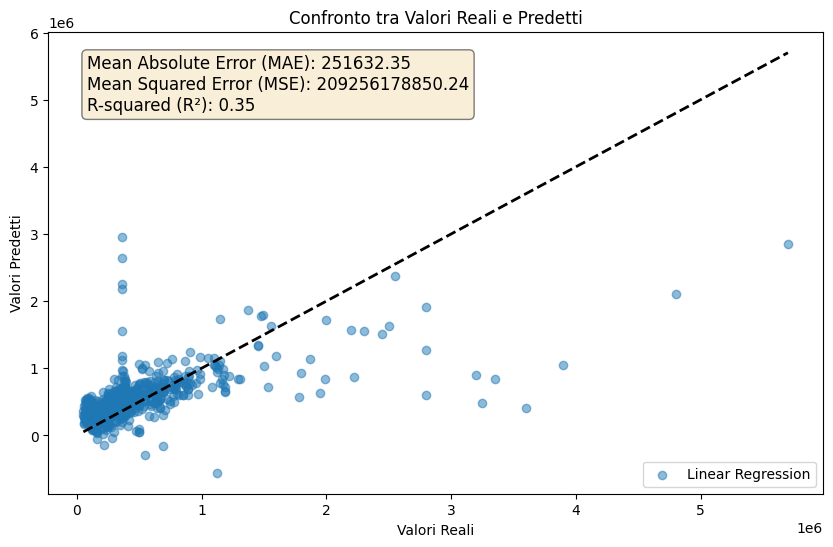

Random Forest - Mean Absolute Error (MAE): 214099.72729497356
Random Forest - Mean Squared Error (MSE): 261078937948.68213
Random Forest - R-squared (R²): 0.18746437408288996


/var/folders/zl/h8y9h0pj3c3cdg2k47s2plw00000gn/T/ipykernel_24920/4073016954.py:203: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


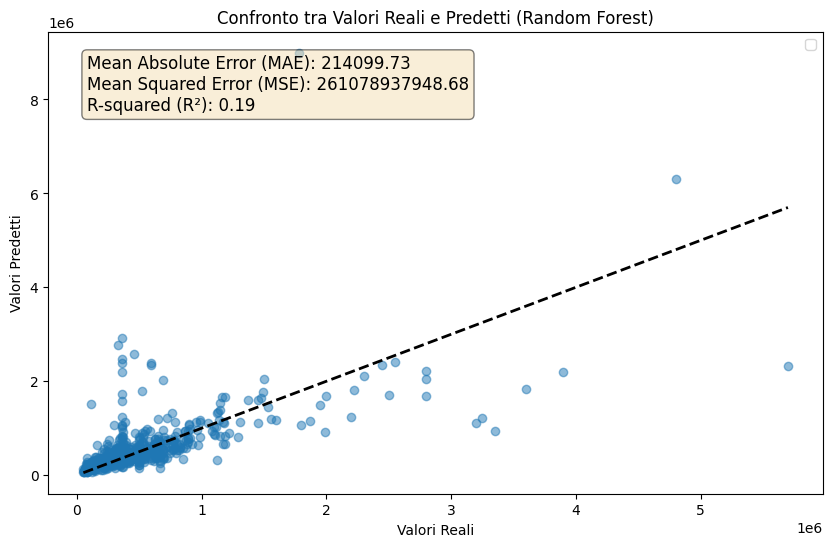

In [49]:
#eseguo una pulizia delle colonne del dataset eliminano di segni o valori non utili e comparo una regressione lineare e un random forest

import pandas as pd
df1= pd.read_csv("/Users/alessandrobragato//0_milan_real_estate/df1.csv")
# Converti tutti i valori testuali in minuscolo
df1 = df1.applymap(lambda s: s.lower() if type(s) == str else s)
# Check if the columns exist in the DataFrame
colonne_da_mantenere = [col for col in ['area_m2','number_rooms','bathrooms', 'condominium fees', 
                        'condition_encoded', 'heating_encoded',
                        'Energy Efficiency Encoded','grid_cell_encoded',
                        'price_euro'] if col in df1.columns]


# Ottieni l'elenco di tutte le colonne nel DataFrame originale
tutte_le_colonne = df1.columns

# Calcola le colonne da eliminare (quelle non incluse in colonne_da_mantenere)
colonne_da_eliminare = [colonna for colonna in tutte_le_colonne if colonna not in colonne_da_mantenere]

# Elimina le colonne non desiderate
df1 = df1.drop(colonne_da_eliminare, axis=1)
# Colonna da modificare
colonna_da_modificare = 'price_euro'

# Rimuovi le parole specifiche dalla colonna di tipo oggetto
df1[colonna_da_modificare] = df1[colonna_da_modificare].str.replace('€', '', regex=False)
df1[colonna_da_modificare] = df1[colonna_da_modificare].str.replace('from', '', regex=False)
df1[colonna_da_modificare] = df1[colonna_da_modificare].str.replace('Price on application', '', regex=False)
df1[colonna_da_modificare] = df1[colonna_da_modificare].str.replace(',', '', regex=False)
# Converti la colonna in valori numerici, forzando i valori non numerici a NaN
df1[colonna_da_modificare] = pd.to_numeric(df1[colonna_da_modificare], errors='coerce')
# Calcola la mediana della colonna ignorando i valori NaN
mediana_price_euro = df1[colonna_da_modificare].median()
# Riempi i valori NaN con la mediana calcolata
df1[colonna_da_modificare].fillna(mediana_price_euro, inplace=True)

# Converti la colonna 'area_m2' in stringa
df1['area_m2'] = df1['area_m2'].astype(str)
# Rimuovi il testo "m²" dalla colonna 'area_m2'
df1['area_m2'] = df1['area_m2'].str.replace('m²', '', regex=False)
# Converti la colonna 'area_m2' in valori numerici, forzando i valori non numerici a NaN
df1['area_m2'] = pd.to_numeric(df1['area_m2'], errors='coerce')
# Calcola la mediana della colonna 'area_m2' ignorando i valori NaN
mediana_area = df1['area_m2'].median()
# Calcola il primo e il terzo quartile per 'area_m2'
Q1_area = df1['area_m2'].quantile(0.25)
Q3_area = df1['area_m2'].quantile(0.75)
# Calcola l'intervallo interquartile (IQR) per 'area_m2'
IQR_area = Q3_area - Q1_area
# Definisci i limiti per identificare gli outlier per la colonna 'area_m2'
lower_bound_area = Q1_area - 1.5 * IQR_area
upper_bound_area = Q3_area + 1.5 * IQR_area
# Sostituisci gli outlier con la mediana
df1.loc[(df1['area_m2'] < lower_bound_area) | (df1['area_m2'] > upper_bound_area), 'area_m2'] = mediana_area
# Riempi i valori NaN con la mediana calcolata
df1['area_m2'].fillna(mediana_area, inplace=True)
# Definisci la colonna da modificare
colonna_da_modificare = 'area_m2'
# Converti la colonna in valori numerici, forzando i valori non numerici a NaN
df1[colonna_da_modificare] = pd.to_numeric(df1[colonna_da_modificare], errors='coerce')
# Calcola la mediana della colonna ignorando i valori NaN
mediana_area = df1[colonna_da_modificare].median()

# Sostituisci i valori al di sotto di 19 con la mediana
df1.loc[df1[colonna_da_modificare] < 19, colonna_da_modificare] = mediana_area
colonna_originale = df1['number_rooms'].copy()
# Converti la colonna 'number_rooms' in stringa
df1['number_rooms'] = df1['number_rooms'].astype(str)
# Rimuovi il testo ",m²" e "m²" dalla colonna 'number_rooms'
df1['number_rooms'] = df1['number_rooms'].str.replace('m²', '', regex=False)
# Converti la colonna 'number_rooms' in valori numerici, forzando i valori non numerici a NaN
df1['number_rooms'] = pd.to_numeric(df1['number_rooms'], errors='coerce')
# Calcola la mediana della colonna 'number_rooms' ignorando i valori NaN
mediana_rooms = df1['number_rooms'].median()
# Riempi i valori NaN e i valori originariamente stringa con la mediana calcolata
df1['number_rooms'].fillna(mediana_rooms, inplace=True)
df1.loc[colonna_originale.isin(df1['number_rooms'].astype(str)), 'number_rooms'] = mediana_rooms

# Converti la colonna 'bathrooms' in stringa
df1['bathrooms'] = df1['bathrooms'].astype(str)
# Rimuovi il testo "m²" dalla colonna 'bathrooms'
df1['bathrooms'] = df1['bathrooms'].str.replace('m²', '', regex=False)
# Converti la colonna 'bathrooms' in valori numerici, forzando i valori non numerici a NaN
df1['bathrooms'] = pd.to_numeric(df1['bathrooms'], errors='coerce')
# Calcola la mediana della colonna 'bathrooms' ignorando i valori NaN
mediana_bathrooms = df1['bathrooms'].median()
# Riempi i valori NaN con la mediana calcolata
df1['bathrooms'].fillna(mediana_bathrooms, inplace=True)

colonna_da_modificare2 = 'condominium fees'
# Converti la colonna in stringa
df1[colonna_da_modificare2] = df1[colonna_da_modificare2].astype(str)
# Rimuovi i caratteri non numerici e parti di testo specifici
df1[colonna_da_modificare2] = df1[colonna_da_modificare2].str.replace('€', '', regex=False)
df1[colonna_da_modificare2] = df1[colonna_da_modificare2].str.replace('/mese', '', regex=False)
df1[colonna_da_modificare2] = df1[colonna_da_modificare2].str.replace('/month', '', regex=False)
# Sostituisci 'No condominium fees' e 'nan' con NaN
df1[colonna_da_modificare2] = df1[colonna_da_modificare2].replace(['No condominium fees', 'nan'], pd.NA)
# Converti la colonna in valori numerici, forzando i valori non numerici a NaN
df1[colonna_da_modificare2] = pd.to_numeric(df1[colonna_da_modificare2], errors='coerce')
# Calcola la mediana della colonna 'condominium fees' ignorando i valori NaN
mediana_condominium_fees = df1[colonna_da_modificare2].median()
# Riempi i valori NaN con la mediana calcolata
df1[colonna_da_modificare2].fillna(mediana_condominium_fees, inplace=True)


# Check if the columns exist in the DataFrame
existing_features = [col for col in ['area_m2','number_rooms','bathrooms', 
                                     'condominium fees','condition_encoded', 
                                     'heating_encoded','Energy Efficiency Encoded',
                                     'grid_cell_encoded'] if col in df1.columns]

# Seleziona le caratteristiche (features) e la variabile target
features = existing_features
target = 'price_euro'

# Drop NaN values in the target column
df1 = df1.dropna(subset=[target])

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X = df1[features]
y = df1[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a linear regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

# Plot the comparison between actual and predicted values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Linear Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Confronto tra Valori Reali e Predetti')

# Aggiungi una legenda con le metriche di valutazione
mae_text = f"Mean Absolute Error (MAE): {mae:.2f}"
mse_text = f"Mean Squared Error (MSE): {mse:.2f}"
r2_text = f"R-squared (R²): {r2:.2f}"

# Create a box with the stats
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = '\n'.join((mae_text, mse_text, r2_text))

# Place the box in the upper left
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', bbox=props)

plt.legend()
plt.show()

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


# Evaluate the model
y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - Mean Absolute Error (MAE): {mae_rf}")
print(f"Random Forest - Mean Squared Error (MSE): {mse_rf}")
print(f"Random Forest - R-squared (R²): {r2_rf}")

# Plot the comparison between actual and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Confronto tra Valori Reali e Predetti (Random Forest)')

# Aggiungi una legenda con le metriche di valutazione
mae_rf_text = f"Mean Absolute Error (MAE): {mae_rf:.2f}"
mse_rf_text = f"Mean Squared Error (MSE): {mse_rf:.2f}"
r2_rf_text = f"R-squared (R²): {r2_rf:.2f}"

# Create a box with the stats
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr_rf = '\n'.join((mae_rf_text, mse_rf_text, r2_rf_text))

# Place the box in the upper left
plt.gca().text(0.05, 0.95, textstr_rf, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', bbox=props)

plt.legend()
plt.show()

Non ottenendo alcun buon risultato ho deciso di concentrarmi solo su 2 celle della griglia elaborata in particolare, grazie alla heatmap ho deciso di concetrarmi sulle celle 30 e 31 per omgeneità dei dati presenti ottenendo 115 righe

In [56]:
import pandas as pd

# Carica il dataset
df1 = pd.read_csv("/Users/alessandrobragato//0_milan_real_estate/df1.csv")

# Filtra le righe riferite alle grid_cell_encoded 30 e 31
df_filtered = df1[df1['grid_cell_encoded'].isin([30, 31])]

# Visualizza le prime righe del DataFrame filtrato per verifica
print(df_filtered.head())
df_filtered.head()
# Salva il DataFrame filtrato in un nuovo file CSV
#df_filtered.to_csv("/Users/alessandrobragato//0_milan_real_estate/df_filtr_30_31.csv", index=False)

    Unnamed: 0   price_euro number_rooms area_m2 bathrooms floor_number  \
6            6    € 369,000            3    84m²         1            1   
31          31    € 129,900            2    53m²         1            G   
50          50    € 240,000            3    75m²         1          NaN   
62          62  € 1,450,000            2   102m²         1            3   
94          94    € 220,000            2    62m²         1            2   

                                          description  \
6   Via Paolo Onorato Vigliani – Fiera. In contest...   
31  Splendido e luminosissimo bilocale nato da un ...   
50  Voglio parlarvi di una casa dotata di numerosi...   
62  MILANO -ZONA CITY LIFE  - All'interno del nuov...   
94  La Capitani Immobiliare propone in vendita bil...   

       Reference and listing Date contract  \
6             T3272I - 10/24/2023     Sale   
31             23561 - 10/24/2023     Sale   
50          Mar Nero - 10/24/2023     Sale   
62  BILOCALE A.S. 3° -

,Unnamed: 0,price_euro,number_rooms,area_m2,bathrooms,floor_number,description,Reference and listing Date,contract,type,...,URL,latitudine,longitudine,lat_bin,lon_bin,grid_cell,grid_cell_encoded,Energy Efficiency Encoded,heating_encoded,condition_encoded
6,6,"€ 369,000",3,84m²,1,1,Via Paolo Onorato Vigliani – Fiera. In contest...,T3272I - 10/24/2023,Sale,Apartment | Full ownership | Stately property ...,...,https://www.immobiliare.it/en/annunci/106893519/,45.481051,9.145716,5,2,"5,2",30,9,0,3
31,31,"€ 129,900",2,53m²,1,G,Splendido e luminosissimo bilocale nato da un ...,23561 - 10/24/2023,Sale,Apartment | Full ownership | Stately property ...,...,https://www.immobiliare.it/en/annunci/106899015/,45.481938,9.168455,5,3,"5,3",31,9,1,1
50,50,"€ 240,000",3,75m²,1,NaN,Voglio parlarvi di una casa dotata di numerosi...,Mar Nero - 10/24/2023,Sale,Apartment | Full ownership | Medium property c...,...,https://www.immobiliare.it/en/annunci/106891863/,45.483285,9.165258,5,3,"5,3",31,5,0,1
62,62,"€ 1,450,000",2,102m²,1,3,MILANO -ZONA CITY LIFE - All'interno del nuov...,BILOCALE A.S. 3° - 10/24/2023,Sale,Apartment | Full ownership | Luxury property,...,https://www.immobiliare.it/en/annunci/106894317/,45.475411,9.153307,5,2,"5,2",30,3,0,0
94,94,"€ 220,000",2,62m²,1,2,La Capitani Immobiliare propone in vendita bil...,PIANA5 - 10/24/2023,Sale,Apartment | Full ownership | Medium property c...,...,https://www.immobiliare.it/en/annunci/106880105/,45.478541,9.177695,5,3,"5,3",31,4,1,1


In [57]:
# Load the dataset
df_filt = pd.read_csv('/Users/alessandrobragato/0_milan_real_estate/df_filtr_30_31.csv')
df_synht = pd.read_csv('/Users/alessandrobragato/0_milan_real_estate/synthetic_dataset_20000_rows.csv')
#unione dei due dataset
df_merged = pd.concat([df_filt, df_synht], ignore_index=True)
#salvo il nuovo df in csv
#df_merged.to_csv('/Users/alessandrobragato/0_milan_real_estate/dfsy.csv', index=False)
dfsy= pd.read_csv('/Users/alessandrobragato/0_milan_real_estate/dfsy.csv')
#controllo il numero di righe
num_rows = dfsy.shape[0]
print(f'The number of rows in the dataframe is: {num_rows}')

The number of rows in the dataframe is: 20115


Ho chiesto a copilot di implementare una regressione e un random forest, con solo 'area_m2', 'number_rooms', 'bathrooms', 'condominium fees' ed in autonomia ha creato un aggregato di feature: 'total_features' che la somma dei valori delle feature del modello

MSE: 4267686503.536217, MAE: 49742.114618886, R²: 0.9321382356377638


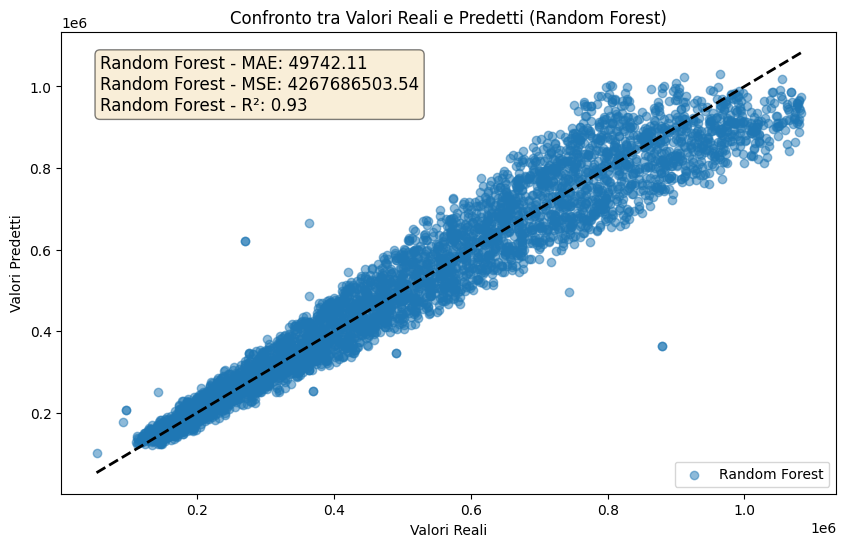

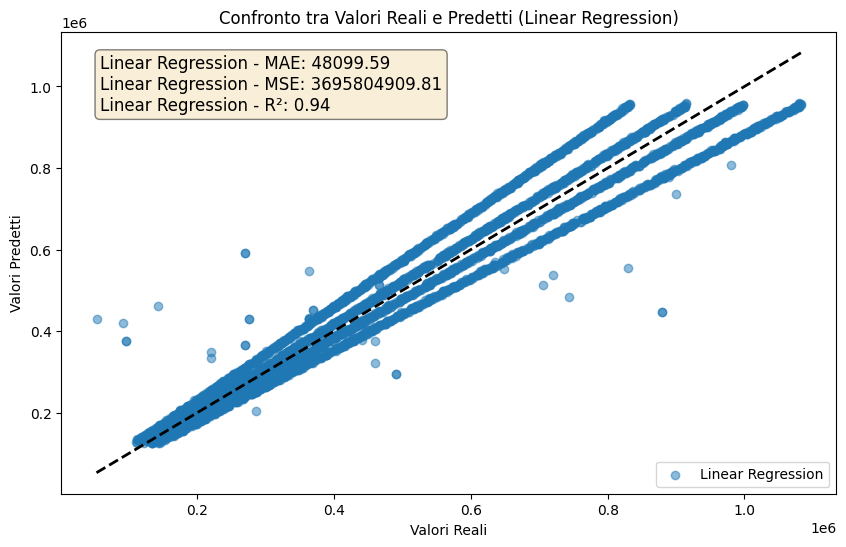

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Carica i dati
dfsth = pd.read_csv("/Users/alessandrobragato//0_milan_real_estate/dfsy.csv")

# Prepara i dati
dfsth['area_m2'] = dfsth['area_m2'].apply(lambda x: int(x + 0.5))
dfsth['condominium fees'] = dfsth['condominium fees'].apply(lambda x: int(x + 0.5))
dfsth['total_features'] = dfsth.apply(
    lambda row: row['area_m2'] + row['number_rooms'] + row['bathrooms'] + row['condominium fees']
    if pd.isna(row['total_features']) else row['total_features'], axis=1
)

# Definisci X e y
X = dfsth[['area_m2', 'number_rooms', 'bathrooms', 'condominium fees', 'total_features']]
y = dfsth['price_euro']

# Dividi i dati in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizza i dati
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
from sklearn.linear_model import LinearRegression

# Addestra un modello RandomForest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)

# Valuta il modello
y_pred = rf.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}, MAE: {mae}, R²: {r2}')
# Addestra un modello di regressione lineare

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Valuta il modello di regressione lineare
y_pred_lr = lr.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Plot the comparison between actual and predicted values for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Confronto tra Valori Reali e Predetti (Random Forest)')

# Aggiungi una legenda con le metriche di valutazione
mae_text = f"Random Forest - MAE: {mae:.2f}"
mse_text = f"Random Forest - MSE: {mse:.2f}"
r2_text = f"Random Forest - R²: {r2:.2f}"

# Create a box with the stats
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = '\n'.join((mae_text, mse_text, r2_text))

# Place the box in the upper left
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', bbox=props)

plt.legend()
plt.show()

# Plot the comparison between actual and predicted values for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5, label='Linear Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Confronto tra Valori Reali e Predetti (Linear Regression)')

# Aggiungi una legenda con le metriche di valutazione
mae_text_lr = f"Linear Regression - MAE: {mae_lr:.2f}"
mse_text_lr = f"Linear Regression - MSE: {mse_lr:.2f}"
r2_text_lr = f"Linear Regression - R²: {r2_lr:.2f}"

# Create a box with the stats
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr_lr = '\n'.join((mae_text_lr, mse_text_lr, r2_text_lr))

# Place the box in the upper left
plt.gca().text(0.05, 0.95, textstr_lr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', bbox=props)

plt.legend()
plt.show()


mi ha creato una feature che è 'total feature', ho deciso di continaure in questa direzione ma eliminando total feature come varabile che era stata utilizzata perchè racchiudeva più caratteristiche dell'immabile in una sola riducendo dimensioalità del dataset, il prblema che la somma artimetica di metri quadri stanze bagni tasse condominiali etc non ha molto senso.
utilizzando solo la regressione lineare



Ho calcolato tramite le coodinate estratte quali fossero i quartieri corrispondendi alle celle da cui sono stati creati i dati sintetici per poter poi aggiungere un nuovo dato, in quelle zone, per valutare i modelli (random forest e linear regression) 

In [81]:
import numpy as np

# Definisci i limiti della griglia
lat_min = 45.4260
lat_max = 45.5100
lon_min = 9.1250
lon_max = 9.2550

# Definisci il numero di celle della griglia
n_cells_lat = 7
n_cells_lon = 7

# Crea la griglia
lat_bins = np.linspace(lat_min, lat_max, n_cells_lat + 1)
lon_bins = np.linspace(lon_min, lon_max, n_cells_lon + 1)

print("Latitudine suddivisa in 7 parti uguali:", lat_bins)
print("Longitudine suddivisa in 7 parti uguali:", lon_bins)

Latitudine suddivisa in 7 parti uguali: [45.426 45.438 45.45  45.462 45.474 45.486 45.498 45.51 ]
Longitudine suddivisa in 7 parti uguali: [9.125      9.14357143 9.16214286 9.18071429 9.19928571 9.21785714
 9.23642857 9.255     ]


inserendo le coordinate su google maps ho trovato che:

30 –> 45.486, 9.14357143 (QT8, Portello, San siro, City life)

31 –> 45.474, 9.16214286 (citylife, sempione, pagano, wagner)

Ho così lasciato lo stesso numero di feature ma utilizzando la posizione che avevano sulla griglia per il Random forest

MSE: 4052757375.762004, MAE: 48900.70278021957, R²: 0.9355558882257664


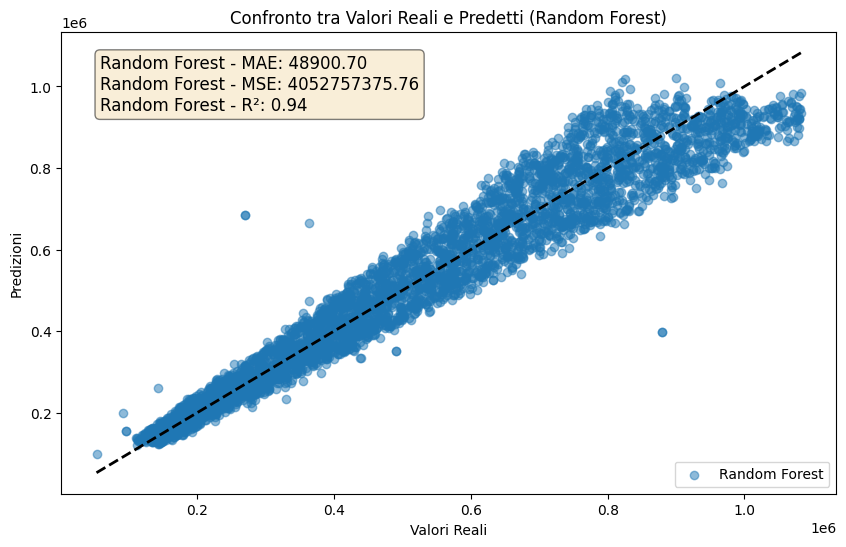

In [83]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Carica i dati
dfsth = pd.read_csv("/Users/alessandrobragato//0_milan_real_estate/dfsy.csv")

# Prepara i dati
dfsth['area_m2'] = dfsth['area_m2'].apply(lambda x: int(x + 0.5))
dfsth['condominium fees'] = dfsth['condominium fees'].apply(lambda x: int(x + 0.5))

# Definisci X e y
X = dfsth[['area_m2', 'number_rooms', 'bathrooms', 'condominium fees', 'grid_cell_encoded']]
y = dfsth['price_euro']

# Dividi i dati in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizza i dati
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Addestra un modello RandomForest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)

# Valuta il modello
y_pred = rf.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}, MAE: {mae}, R²: {r2}')

# Visualizza un grafico (opzionale)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valori Reali')
plt.ylabel('Predizioni')
plt.title('Confronto tra Valori Reali e Predetti (Random Forest)')

# Aggiungi una legenda con le metriche di valutazione
mae_text = f"Random Forest - MAE: {mae:.2f}"
mse_text = f"Random Forest - MSE: {mse:.2f}"
r2_text = f"Random Forest - R²: {r2:.2f}"

# Create a box with the stats
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = '\n'.join((mae_text, mse_text, r2_text))

# Place the box in the upper left
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', bbox=props)

plt.legend()
plt.show()





E ho porvato anche le performance del modello random forest con tutti le feature

MSE: 310817262.8976125, MAE: 3709.6361088879676, R²: 0.99505760138731


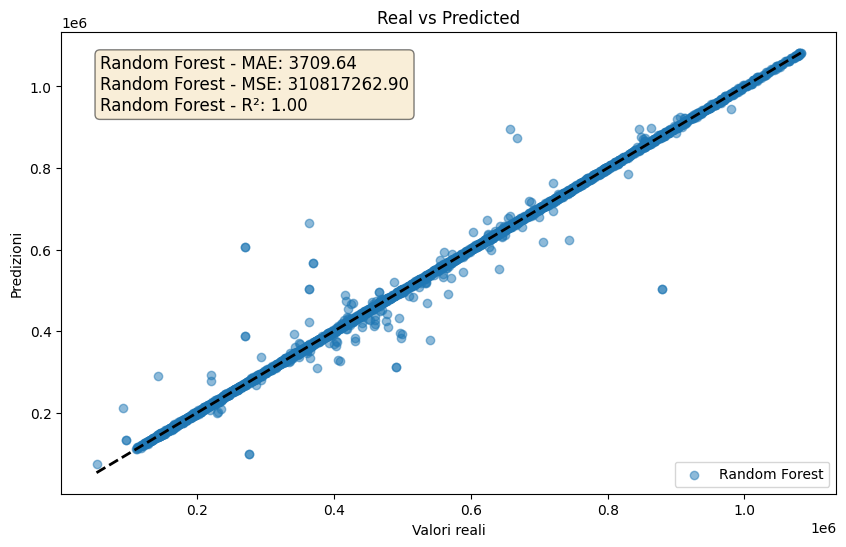

In [84]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Carica i dati
dfsth = pd.read_csv("/Users/alessandrobragato//0_milan_real_estate/dfsy.csv")

# Prepara i dati
dfsth['area_m2'] = dfsth['area_m2'].apply(lambda x: int(x + 0.5))
dfsth['condominium fees'] = dfsth['condominium fees'].apply(lambda x: int(x + 0.5))

# Definisci X e y
X = dfsth[['area_m2', 'number_rooms', 'bathrooms', 'condominium fees',
           'condition_encoded','heating_encoded','Energy Efficiency Encoded']]
y = dfsth['price_euro']

# Dividi i dati in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizza i dati
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Addestra un modello RandomForest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)

# Valuta il modello
y_pred = rf.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}, MAE: {mae}, R²: {r2}')

# Visualizza un grafico (opzionale)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valori reali')
plt.ylabel('Predizioni')
plt.title('Real vs Predicted')

# Aggiungi una legenda con le metriche di valutazione
mae_text = f"Random Forest - MAE: {mae:.2f}"
mse_text = f"Random Forest - MSE: {mse:.2f}"
r2_text = f"Random Forest - R²: {r2:.2f}"

# Create a box with the stats
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = '\n'.join((mae_text, mse_text, r2_text))

# Place the box in the upper left
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', bbox=props)

plt.legend()
plt.show()

vedo come perfroma il modello ***linear regression*** con le coordinate codificate

MSE: 3732261900.991697, MAE: 48154.6247534321, R²: 0.9406521829910928


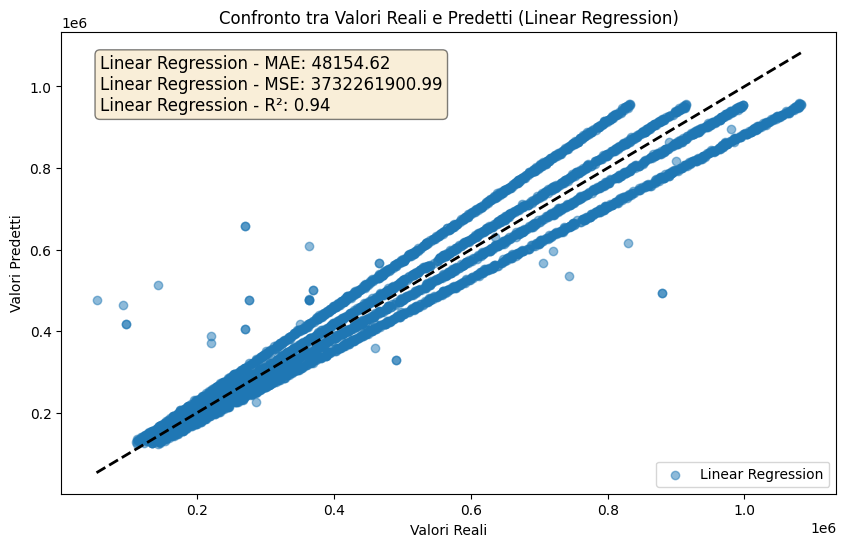

In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

# Carica i dati
dfsth = pd.read_csv("/Users/alessandrobragato//0_milan_real_estate/dfsy.csv")

# Prepara i dati
dfsth['area_m2'] = dfsth['area_m2'].apply(lambda x: int(x + 0.5))
dfsth['condominium fees'] = dfsth['condominium fees'].apply(lambda x: int(x + 0.5))

# Definisci X e y
X = dfsth[['area_m2', 'number_rooms', 'bathrooms', 'condominium fees', 'grid_cell_encoded']]
y = dfsth['price_euro']

# Dividi i dati in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizza i dati
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Addestra un modello di regressione lineare
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Valuta il modello di regressione lineare
y_pred_lr = lr.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f'MSE: {mse_lr}, MAE: {mae_lr}, R²: {r2_lr}')

# Plot the comparison between actual and predicted values for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5, label='Linear Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Confronto tra Valori Reali e Predetti (Linear Regression)')

# Aggiungi una legenda con le metriche di valutazione
mae_text_lr = f"Linear Regression - MAE: {mae_lr:.2f}"
mse_text_lr = f"Linear Regression - MSE: {mse_lr:.2f}"
r2_text_lr = f"Linear Regression - R²: {r2_lr:.2f}"

# Create a box with the stats
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr_lr = '\n'.join((mae_text_lr, mse_text_lr, r2_text_lr))

# Place the box in the upper left
plt.gca().text(0.05, 0.95, textstr_lr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', bbox=props)

plt.legend()
plt.show()

vedo come perfroma il modello ***linear regression*** con tutte le feature scelte

MSE: 1060354628.4296056, MAE: 20091.13118789027, R²: 0.9831389827075461


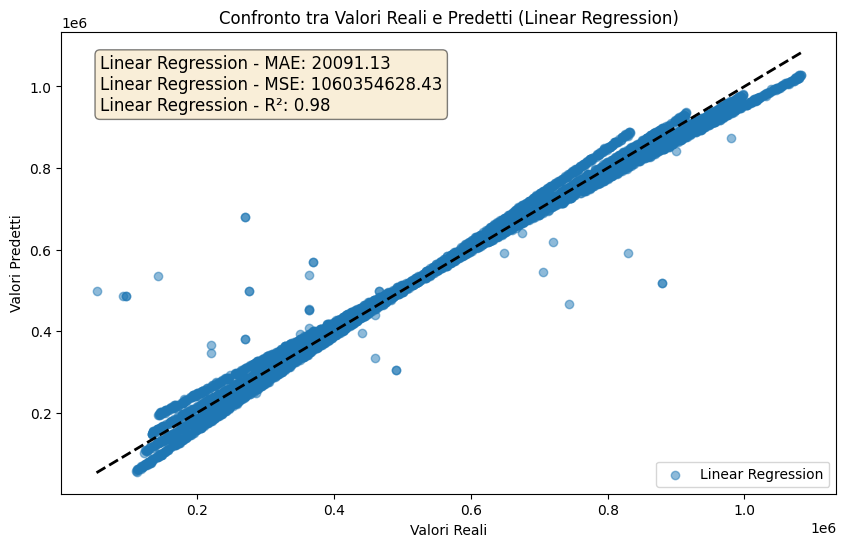

In [86]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

# Carica i dati
dfsth = pd.read_csv("/Users/alessandrobragato//0_milan_real_estate/dfsy.csv")

# Prepara i dati
dfsth['area_m2'] = dfsth['area_m2'].apply(lambda x: int(x + 0.5))
dfsth['condominium fees'] = dfsth['condominium fees'].apply(lambda x: int(x + 0.5))

# Definisci X e y
X = dfsth[['area_m2', 'number_rooms', 'bathrooms', 'condominium fees',
           'condition_encoded','heating_encoded','Energy Efficiency Encoded',
           ]]
y = dfsth['price_euro']
# Dividi i dati in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizza i dati
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Addestra un modello di regressione lineare
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Valuta il modello di regressione lineare
y_pred_lr = lr.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f'MSE: {mse_lr}, MAE: {mae_lr}, R²: {r2_lr}')

# Plot the comparison between actual and predicted values for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5, label='Linear Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Confronto tra Valori Reali e Predetti (Linear Regression)')

# Aggiungi una legenda con le metriche di valutazione
mae_text_lr = f"Linear Regression - MAE: {mae_lr:.2f}"
mse_text_lr = f"Linear Regression - MSE: {mse_lr:.2f}"
r2_text_lr = f"Linear Regression - R²: {r2_lr:.2f}"

# Create a box with the stats
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr_lr = '\n'.join((mae_text_lr, mse_text_lr, r2_text_lr))

# Place the box in the upper left
plt.gca().text(0.05, 0.95, textstr_lr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', bbox=props)

plt.legend()
plt.show()

Ho deciso di concentrarmi solo sui modelli con grid_cell quindi con meno features rispetto agli altri visti i risultati 

1. test del modello random forest ***less_feature*** con un immobile **furoi** alle celle 30 e 31

MSE: 4052757375.762004, MAE: 48900.70278021957, R²: 0.9355558882257664


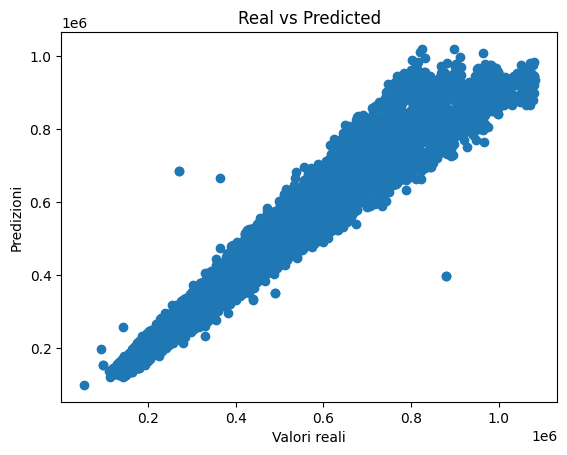

Predizione Random Forest: 630194.3609801801


In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

# Carica i dati
dfsth = pd.read_csv("/Users/alessandrobragato//0_milan_real_estate/dfsy.csv")

# Prepara i dati
dfsth['area_m2'] = dfsth['area_m2'].apply(lambda x: int(x + 0.5))
dfsth['condominium fees'] = dfsth['condominium fees'].apply(lambda x: int(x + 0.5))

# Definisci X e y
X = dfsth[['area_m2', 'number_rooms', 'bathrooms', 'condominium fees', 'grid_cell_encoded']]
y = dfsth['price_euro']

# Dividi i dati in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizza i dati
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Addestra un modello RandomForest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)

# Valuta il modello
y_pred = rf.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}, MAE: {mae}, R²: {r2}')

# Visualizza un grafico (opzionale)
plt.scatter(y_test, y_pred)
plt.xlabel('Valori reali')
plt.ylabel('Predizioni')
plt.title('Real vs Predicted')
plt.show()

# Aggiungi un nuovo dato
new_data = pd.DataFrame({
    'area_m2': [100],
    'number_rooms': [3],
    'bathrooms': [1],
    'condominium fees': [200],
    'grid_cell_encoded': [17]
})

# Standardizza il nuovo dato
new_data_scaled = scaler.transform(new_data)

# Predici il prezzo usando il modello RandomForest
pred_rf = rf.predict(new_data_scaled)

print(f'Predizione Random Forest: {pred_rf[0]}')

2. test del modello random forest ***less_feature*** con un immobile ***dento** le celle 30 e 31

MSE: 4052757375.762004, MAE: 48900.70278021957, R²: 0.9355558882257664


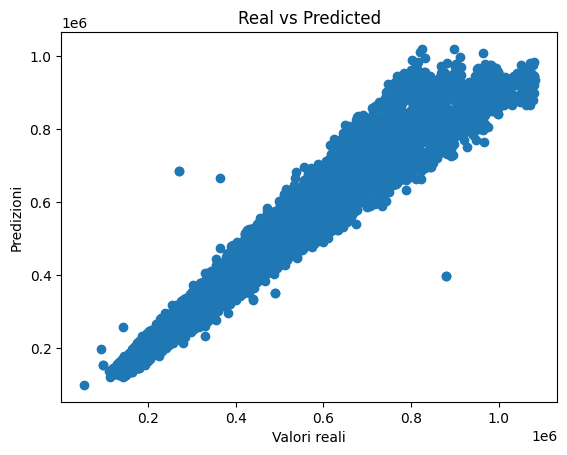

Predizione Random Forest: 881181.4243285503


In [69]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Carica i dati
dfsth = pd.read_csv("/Users/alessandrobragato//0_milan_real_estate/dfsy.csv")

# Prepara i dati
dfsth['area_m2'] = dfsth['area_m2'].apply(lambda x: int(x + 0.5))
dfsth['condominium fees'] = dfsth['condominium fees'].apply(lambda x: int(x + 0.5))

# Definisci X e y
X = dfsth[['area_m2', 'number_rooms', 'bathrooms', 'condominium fees', 'grid_cell_encoded']]
y = dfsth['price_euro']

# Dividi i dati in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizza i dati
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Addestra un modello RandomForest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)

# Valuta il modello
y_pred = rf.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}, MAE: {mae}, R²: {r2}')

# Visualizza un grafico (opzionale)
plt.scatter(y_test, y_pred)
plt.xlabel('Valori reali')
plt.ylabel('Predizioni')
plt.title('Real vs Predicted')
plt.show()
# Aggiungi un nuovo dato
new_data = pd.DataFrame({
    'area_m2': [160],
    'number_rooms': [3],
    'bathrooms': [2],
    'condominium fees': [420],
    'grid_cell_encoded': [31]  
})

# Standardizza il nuovo dato
new_data_scaled = scaler.transform(new_data)

# Predici il prezzo usando il modello RandomForest
pred_rf = rf.predict(new_data_scaled)

print(f'Predizione Random Forest: {pred_rf[0]}')

3. test del modello ***linear regression*** less_feature con un immobile **fuori**  dalle celle 30 e 31

MSE: 3732261900.991697, MAE: 48154.6247534321, R²: 0.9406521829910928


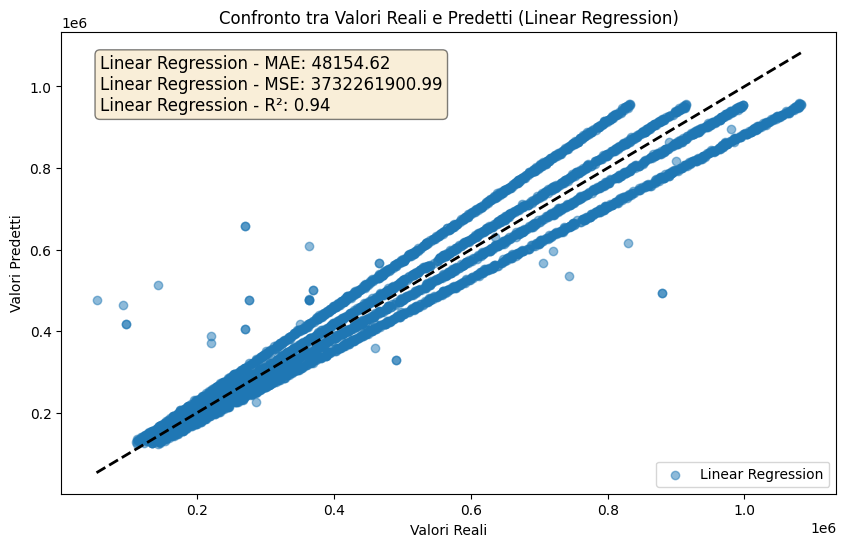

Predizione Linear Regression: 595748.1311873873


In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Carica i dati
dfsth = pd.read_csv("/Users/alessandrobragato//0_milan_real_estate/dfsy.csv")

# Prepara i dati
dfsth['area_m2'] = dfsth['area_m2'].apply(lambda x: int(x + 0.5))
dfsth['condominium fees'] = dfsth['condominium fees'].apply(lambda x: int(x + 0.5))

# Definisci X e y
X = dfsth[['area_m2', 'number_rooms', 'bathrooms', 'condominium fees', 'grid_cell_encoded']]
y = dfsth['price_euro']

# Dividi i dati in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizza i dati
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Addestra un modello di regressione lineare
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Valuta il modello di regressione lineare
y_pred = lr.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}, MAE: {mae}, R²: {r2}')

# Visualizza un grafico (opzionale)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Linear Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Confronto tra Valori Reali e Predetti (Linear Regression)')

# Aggiungi una legenda con le metriche di valutazione
mae_text = f"Linear Regression - MAE: {mae:.2f}"
mse_text = f"Linear Regression - MSE: {mse:.2f}"
r2_text = f"Linear Regression - R²: {r2:.2f}"

# Create a box with the stats
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = '\n'.join((mae_text, mse_text, r2_text))

# Place the box in the upper left
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', bbox=props)

plt.legend()
plt.show()

# Aggiungi un nuovo dato
new_data = pd.DataFrame({
    'area_m2': [100],
    'number_rooms': [3],
    'bathrooms': [1],
    'condominium fees': [200],
    'grid_cell_encoded': [17]
})

# Standardizza il nuovo dato
new_data_scaled = scaler.transform(new_data)

# Predici il prezzo usando il modello di regressione lineare
pred_lr = lr.predict(new_data_scaled)

print(f'Predizione Linear Regression: {pred_lr[0]}')


4. test ddel modello di regressione ***less_feature*** con immobile ***dentro** 30 31

MSE: 3732261900.991697, MAE: 48154.6247534321, R²: 0.9406521829910928


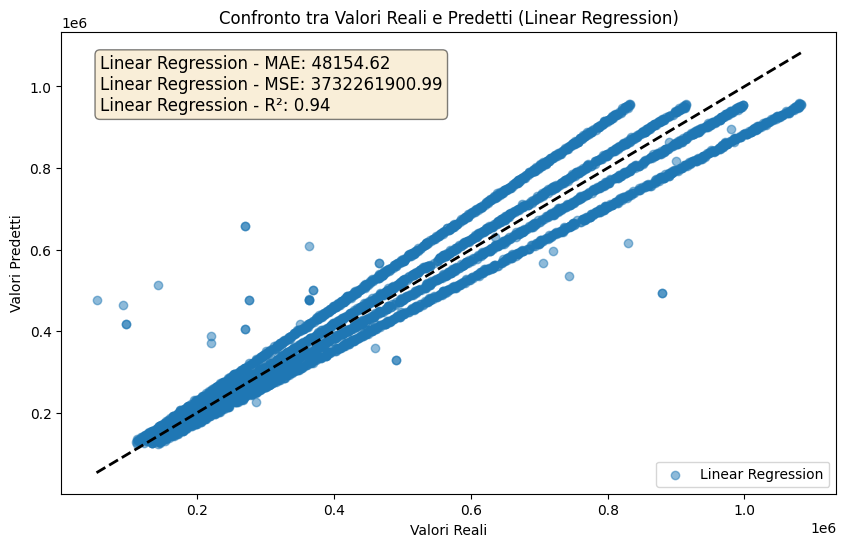

Predizione Linear Regression: 955762.7992451009


In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Carica i dati
dfsth = pd.read_csv("/Users/alessandrobragato//0_milan_real_estate/dfsy.csv")

# Prepara i dati
dfsth['area_m2'] = dfsth['area_m2'].apply(lambda x: int(x + 0.5))
dfsth['condominium fees'] = dfsth['condominium fees'].apply(lambda x: int(x + 0.5))

# Definisci X e y
X = dfsth[['area_m2', 'number_rooms', 'bathrooms', 'condominium fees', 'grid_cell_encoded']]
y = dfsth['price_euro']

# Dividi i dati in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizza i dati
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Addestra un modello di regressione lineare
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Valuta il modello di regressione lineare
y_pred = lr.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}, MAE: {mae}, R²: {r2}')

# Visualizza un grafico (opzionale)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Linear Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Confronto tra Valori Reali e Predetti (Linear Regression)')

# Aggiungi una legenda con le metriche di valutazione
mae_text = f"Linear Regression - MAE: {mae:.2f}"
mse_text = f"Linear Regression - MSE: {mse:.2f}"
r2_text = f"Linear Regression - R²: {r2:.2f}"

# Create a box with the stats
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = '\n'.join((mae_text, mse_text, r2_text))

# Place the box in the upper left
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', bbox=props)

plt.legend()
plt.show()

# Aggiungi un nuovo dato
new_data = pd.DataFrame({
'area_m2': [160],
    'number_rooms': [3],
    'bathrooms': [2],
    'condominium fees': [420],
    'grid_cell_encoded': [31]  
})

# Standardizza il nuovo dato
new_data_scaled = scaler.transform(new_data)

# Predici il prezzo usando il modello di regressione lineare
pred_lr = lr.predict(new_data_scaled)

print(f'Predizione Linear Regression: {pred_lr[0]}')
